<a href="https://colab.research.google.com/github/RWLab/crypto-pod/blob/main/research/trend-momentum-spot-analysis/6_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulating a Cross-Sectional Momentum Strategy

## Load libraries and set plot defaults

In [1]:
# snippet: rw load rwRtools v0.8
source("https://raw.githubusercontent.com/RWLab/rwRtools/master/examples/colab/load_libraries.R")
debug_msg <- load_libraries(load_rsims = TRUE, extra_libraries = c('lubridate'), extra_dependencies = c())

# cat(debug_msg)

# Set chart options
options(repr.plot.width = 14, repr.plot.height=7)
theme_set(theme_bw())
theme_update(text = element_text(size = 20))

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/RtmpK5wcrs/remotes7a5de4aa09/RWLab-rwRtools-1924b0b/DESCRIPTION’ ... OK
* preparing ‘rwRtools’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
Omitted ‘LazyData’ from DESCRIPTION
  NB: this package now depends on R (>= 3.5.0)
  serialize/load version 3 cannot be read in older versions of R.
  File(s) containing such objects:
    ‘rwRtools/R/sysdata.rda’
* building ‘rwRtools_0.1.33.tar.gz’

── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/RtmpK5wcrs/remotes7a8adba13/Robot-Wealth-rsims-2589683/DESCRIPTION’ ... OK
* preparing ‘rsims’:
* checking DESCRIPTION meta-information ... OK
* cleaning src
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directori

## Auth and load data

In [2]:
# snippet: rw data auth v.0.1
rwlab_data_auth()
# snippet: rw crypto quickstart v.0.1
quicksetup(pod = "Crypto", path = ".")
head(prices)

Authorization successful!

Set default bucket name to 'crypto_research_pod'



Attempting download of  coinmetrics.csv ...
Transferring coinmetrics.csv ... data is 2.4 Mb please be patient...


ℹ Downloading coinmetrics.csv

✔ Saved coinmetrics.csv to ./coinmetrics.csv  ( 2.4 Mb )





coinmetrics.csv successfully transferred


Rows: 49183 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): ticker
dbl  (2): price_usd, market_cap
date (1): date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


prices data object transferred and loaded as data.frame to Global Env


ticker,date,price_usd,market_cap
<chr>,<date>,<dbl>,<dbl>
1INCH,2020-12-26,1.6193281,2428992153
1INCH,2020-12-27,1.0723502,1608525301
1INCH,2020-12-28,1.1046742,1657011227
1INCH,2020-12-29,0.8937904,1340685538
1INCH,2020-12-30,1.1013066,1651959828
1INCH,2020-12-31,1.3652374,2047856106


## Create momentum feature

Create momentum feature before creating universe so that our universe consists of the top n coins by market cap *for which we have a momentum feature value.* 

If we create the universe first, then calculate features on that universe, we can have coins in the universe that have no available momentum feature (for instnace during the coin's early life when we are unable to calculate a momentum feature over a lookback period).

Here we calculate a 20-day momentum feature to use as an example.

In [3]:
prices <- prices %>%
  group_by(ticker) %>%
  arrange(date) %>%
  # Calculate 20d momentum feature
  mutate(
    momo20 = price_usd / lag(price_usd, n = 20) - 1
  ) %>% 
  na.omit() %>%
  ungroup()

head(prices)

ticker,date,price_usd,market_cap,momo20
<chr>,<date>,<dbl>,<dbl>,<dbl>
BTC,2010-08-07,0.05900395,215104.8,-0.31262879
BTC,2010-08-08,0.06090000,222623.0,-0.24628713
BTC,2010-08-09,0.07040000,258019.5,-0.05801414
BTC,2010-08-10,0.06933873,254792.1,-0.12443210
BTC,2010-08-11,0.06700000,246978.8,0.14589148
BTC,2010-08-12,0.07000000,258797.0,0.15525144


## Create market-cap universe

In [4]:
# snippet: rw crypto flag universe consituents v0.1
create_universe <- function(prices, n = 10, min_constituents = 10) {
  # snippet: rw crypto remove stablecoins v0.2
  # Remove stablecoins from data set
  prices <- prices %>% 
    filter(!ticker %in% c('BUSD','DAI','GUSD','HUSD','PAX','SAI','TUSD','USDC','USDK','USDT','USDT_ETH','USDT_OMNI','USDT_TRX', 'XAUT')) 
  # snippet: rw crypto remove duplicates v0.1
  # Remove duplicate protocol coins from data set
  prices <- prices %>% 
    filter(!ticker %in% c('BNB_ETH','LEO_EOS','RENBTC', 'WNXM', 'WETH', 'WBTC'))

  # Get first date where we have min_constituents
  start_date <- prices %>%
    group_by(date) %>%
    summarise(count = n()) %>%
    filter(count >= min_constituents) %>%
    summarise(mindate = min(date)) %>%
    pull(mindate)

  # Flag universe consitutents
  # For a given ticker/date observation, set is_index to TRUE if:
  #    - the asset was in the top 10 coins by market cap the day before
  #    - the date is on or after the date when we have min_consituents assets in our dataset
  prices %>%
    group_by(date) %>%
    mutate(cap_rank = row_number(desc(market_cap))) %>%
    arrange(date) %>%
    group_by(ticker) %>%
    mutate(is_index = lag(cap_rank) <= n & date >= start_date) %>%
    # na.omit() %>%
    ungroup()
}

In [5]:
universe_size <- 10
universe <- create_universe(prices, n = universe_size, min_constituents = 10)
head(universe)

universe_start_date <- universe %>% 
  filter(is_index == TRUE) %>% 
  group_by(date) %>%
  summarise(index_count = sum(is_index)) %>%
  filter(index_count >= universe_size) %>%
  summarise(first_index_date = first(date)) %>% 
  pull()

universe_start_date

ticker,date,price_usd,market_cap,momo20,cap_rank,is_index
<chr>,<date>,<dbl>,<dbl>,<dbl>,<int>,<lgl>
BTC,2010-08-07,0.05900395,215104.8,-0.31262879,1,FALSE
BTC,2010-08-08,0.06090000,222623.0,-0.24628713,1,FALSE
BTC,2010-08-09,0.07040000,258019.5,-0.05801414,1,FALSE
BTC,2010-08-10,0.06933873,254792.1,-0.12443210,1,FALSE
BTC,2010-08-11,0.06700000,246978.8,0.14589148,1,FALSE
BTC,2010-08-12,0.07000000,258797.0,0.15525144,1,FALSE


[1] "2017-10-18"

## Simulation

### Simulation function

TODO:
- Consider refactoring 
- Pull out update positions logic into function - make it so that we can use different methods by calling different functions

In [6]:
#' Cash Accounting Backtest
#'
#' @param prices Matrix of trade prices. Column 1 must be the timestamp or index.
#' @param theo_weights Matrix of theoretical weights. Column 1 must be the timestamp or index.
#' @param trade_buffer Trade buffer parameter
#' @param initial_cash Inital cash balance
#' @param commission_pct Percent commission charged on trades
#' @param capitalise_profits If TRUE, utilise profits and initial cash balance in determining position sizes. If FALSE, profits accrue as a cash balance and are not reinvested.
#'
#' @return long dataframe of results - dates, trades, commissions, value of portfolio components 
#' @details
#' `theo_weights` should be date-aligned with `prices` - it is up to the user to lag `theo_weights` as necessary to 
#' ensure that trades occur at appropriate prices.
cash_backtest <- function(prices, theo_weights, trade_buffer = 0., initial_cash = 10000, commission_pct = 0, capitalise_profits = FALSE) {
  # get tickers for later
  tickers <- colnames(prices)[-1] %>% 
    stringr::str_remove("price_usd_")
  
  # initial state
  num_assets <- ncol(prices) - 1  # -1 for date column
  current_positions <- rep(0, num_assets)
  previous_theo_weights <- rep(0, num_assets)
  row_list <- vector(mode = "list", length = nrow(prices))  # preallocate for slight speedup
  cash <- initial_cash
  
  # backtest loop
  for(i in 1:nrow(prices)) {
    # TODO: does wrapping in as.numeric() speed up? (creates array as opposed to named vector). Don't need the names later?
    # TODO: check that date is first column in backtest_theo_weights and backtest_prices
    current_date <- prices[i, "date"]
    current_prices <- prices[i, -1]
    current_theo_weights <- theo_weights[i, -1]
    
    # update equity
    equity <- sum(current_positions * current_prices, na.rm = TRUE) + cash
    cap_equity <- ifelse(capitalise_profits, equity, min(initial_cash, equity))  # min reflects assumption that we don't top up strategy equity if in drawdown
    
    # update positions based on no-trade buffer
    # TODO: consider commissions in calculating position sizes (otherwise can go over leverage 1)
    current_weights <- current_positions*current_prices/cap_equity
    target_positions <- current_positions
    for(j in 1:num_assets) {
      if(is.na(current_theo_weights[j]) || current_theo_weights[j] == 0) {
        target_positions[j] <- 0
        next
      }
      # note: we haven't truncated to nearest whole coin, as coins are divisible (unlike shares)
      if(current_weights[j] < current_theo_weights[j] - trade_buffer) {
        target_positions[j] <- (current_theo_weights[j] - trade_buffer)*cap_equity/current_prices[j]
      } else if(current_weights[j] > current_theo_weights[j] + trade_buffer) {
        target_positions[j] <- (current_theo_weights[j] + trade_buffer)*cap_equity/current_prices[j]
      }
    }
    
    # calculate position deltas, trade values and commissions
    trades <- target_positions - current_positions
    trade_value <- trades * current_prices
    commissions <- abs(trade_value) * commission_pct
    
    # adjust cash by value of trades
    cash <- cash - sum(trade_value, na.rm = TRUE) - sum(commissions, na.rm = TRUE)
    current_positions <- target_positions
    position_value <- current_positions * current_prices
    equity <- sum(position_value, na.rm = TRUE) + cash
    
    # store date in matrix as numeric (then convert date back to date format later)
      row_mat <- matrix(
        data = c(
          rep(as.numeric(current_date), num_assets + 1),
          c(1, current_prices),
          c(0, current_positions),
          c(cash, position_value),
          c(0, trades),
          c(-sum(trade_value), trade_value),
          c(0, commissions)
        ),
        nrow = num_assets + 1,
        ncol = 7,
        byrow = FALSE,
        dimnames = list(
          # tickers are row names
          c("Cash", tickers),
          # column names
          c("Date", "Close", "Position", "Value", "Trades", "TradeValue", "Commission")
        )
      )
    
    row_list[[i]] <- row_mat
    
    previous_theo_weights <- current_theo_weights
  }
  
  # Combine list of matrixes into dataframe
  do.call(rbind, row_list) %>%
    as_tibble(rownames = "ticker") %>%
    mutate(
      Date = as.Date(Date, origin ="1970-01-01")
    )
}

### Make wide dataframe with backtest prices and aligned signals

This is where we convert our factor(s) into wide matrixes of target weights and prices.  Many ways to do this - here we allocate a weight proportional to the rank of the momentum feature and allow long and short positions. 

Regardless of how it's done, the end results needs to be a (wide) matrix of prices and a (wide) matrix of theoretical weights. Weights need to be date-aligned with the price at which they are traded. Here, we assume we can trade at the close on the day of the signal.

For the first 21 days of our universe, we have 9 tradable assets because when the tenth asset gets added, it needs 20 days to calculate the first momo20 value.

In [7]:
# weight by rank (mean(rank) - rank), scaled to abs(weight) = 1, long-short
backtest_df <- universe %>% 
  filter(date >= universe_start_date) %>% 
  select(ticker, date, price_usd, is_index, momo20) %>% 
  # can't filter on is_index because we need price on day after it drops out of index
  # instead, replace momo values with NA if not in index then rank each day
  mutate(universe_momo20 = case_when(is_index == TRUE ~ momo20, TRUE ~ NA_real_)) %>%
  group_by(date) %>%
  mutate(
    rank = row_number(universe_momo20),
    weight = rank - mean(rank, na.rm = TRUE),
    theo_weight = weight/(sum(abs(weight), na.rm = TRUE))
  ) %>% 
  select(ticker, date, price_usd, theo_weight) %>% 
  pivot_wider(names_from = ticker, values_from = c(price_usd, theo_weight))  # pivot wider guarantees prices and theo_weight are date aligned

head(backtest_df)

date,price_usd_BCH,price_usd_BNB,price_usd_BTC,price_usd_DOGE,price_usd_ETH,price_usd_KNC,price_usd_LTC,price_usd_OMG,price_usd_XRP,⋯,theo_weight_BAL,theo_weight_YFI,theo_weight_SRM,theo_weight_CRV,theo_weight_SUSHI,theo_weight_UNI,theo_weight_AAVE,theo_weight_ALPHA,theo_weight_1INCH,theo_weight_PERP
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2017-10-18,338.7678,1.317849,5583.870,0.0010289347,313.2929,1.162461,60.69765,7.854567,0.2180179,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2017-10-19,329.9444,1.286488,5708.313,0.0010451067,308.3612,1.114841,59.78077,7.827557,0.2137977,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2017-10-20,327.3707,1.240682,6000.883,0.0010452918,304.1048,1.044030,60.26844,7.305775,0.2075473,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2017-10-21,322.5177,1.233071,6030.208,0.0009986687,299.9645,1.025443,58.05432,7.405425,0.2081025,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2017-10-22,330.7723,1.215623,5996.598,0.0010439447,294.8625,1.007951,56.64666,7.724162,0.2014042,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2017-10-23,312.0320,1.181881,5888.250,0.0010124827,285.2723,0.957936,54.64016,7.693838,0.1936669,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


Conduct some checks on our backtest dataframe:
* weights sum to 1 every day
* maximum and minimum weights are consistent
* number of non-NA positions is consistent

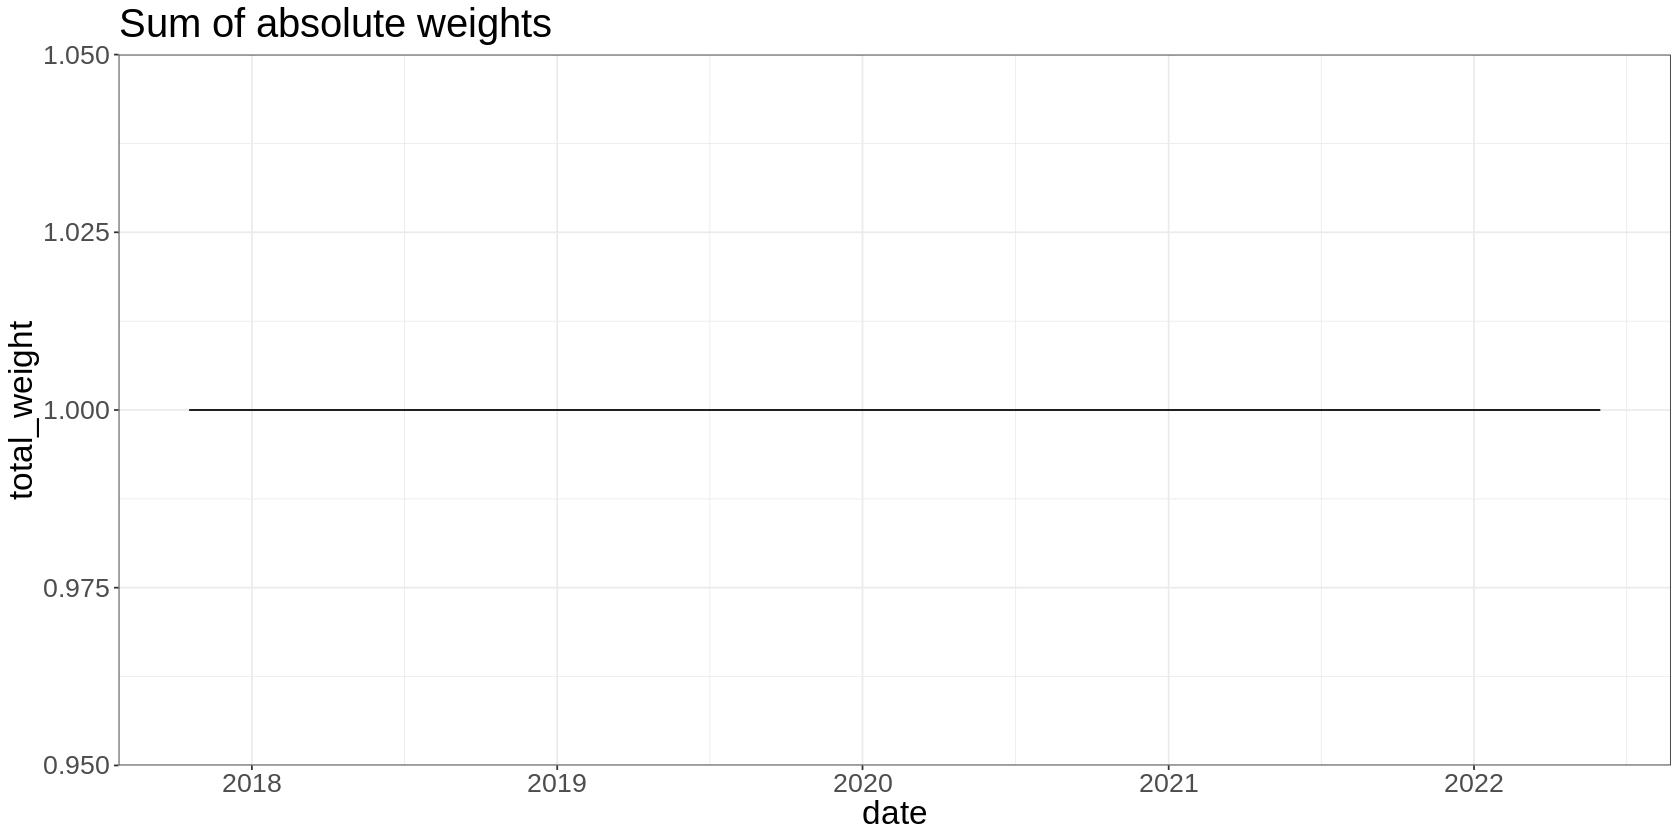

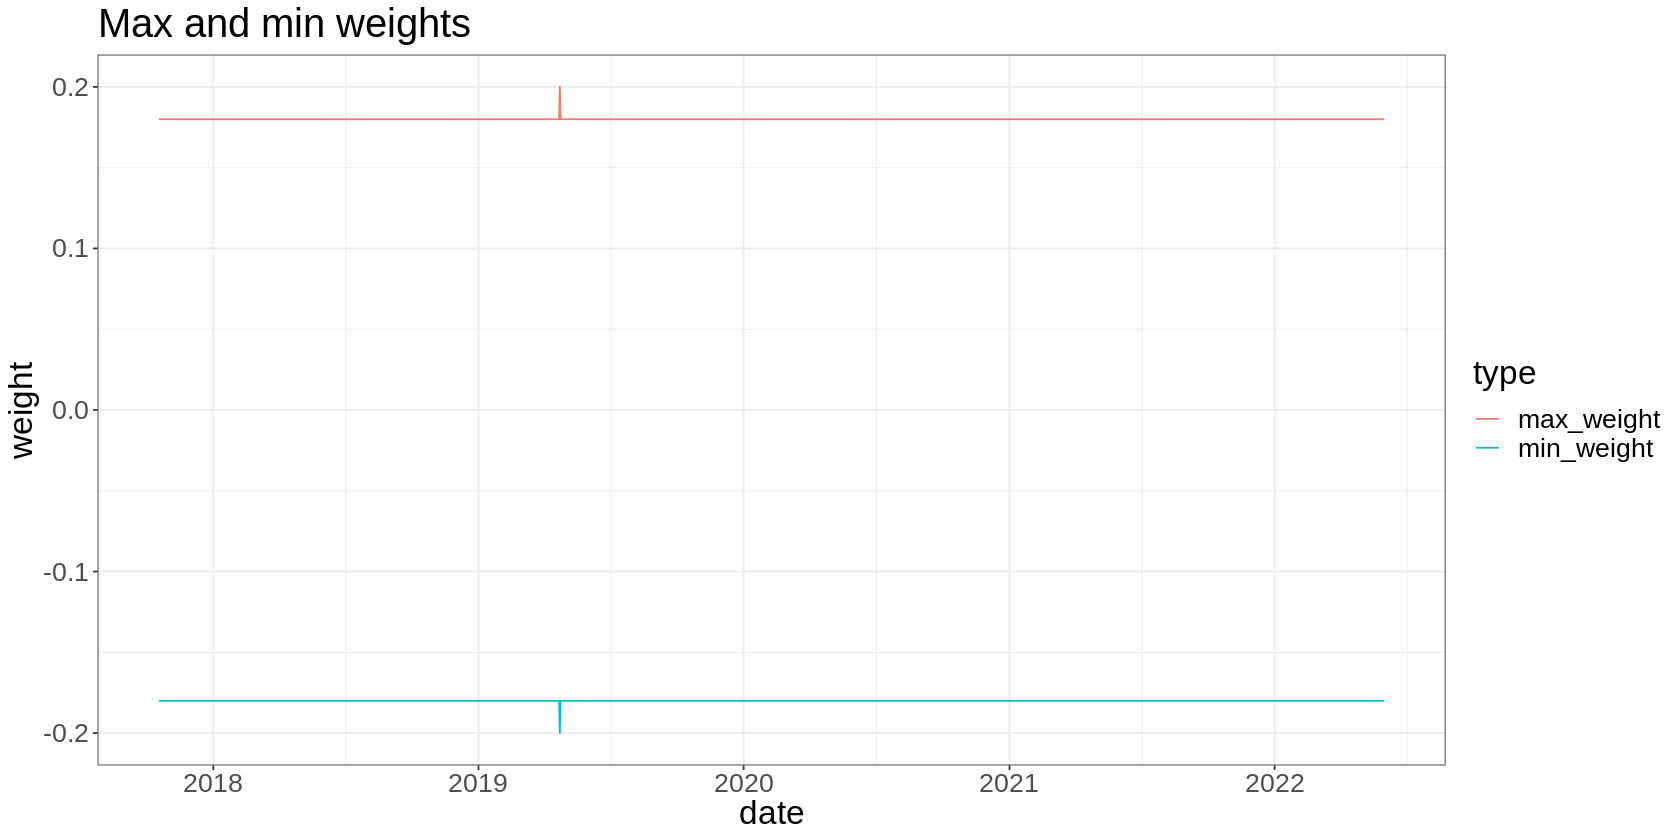

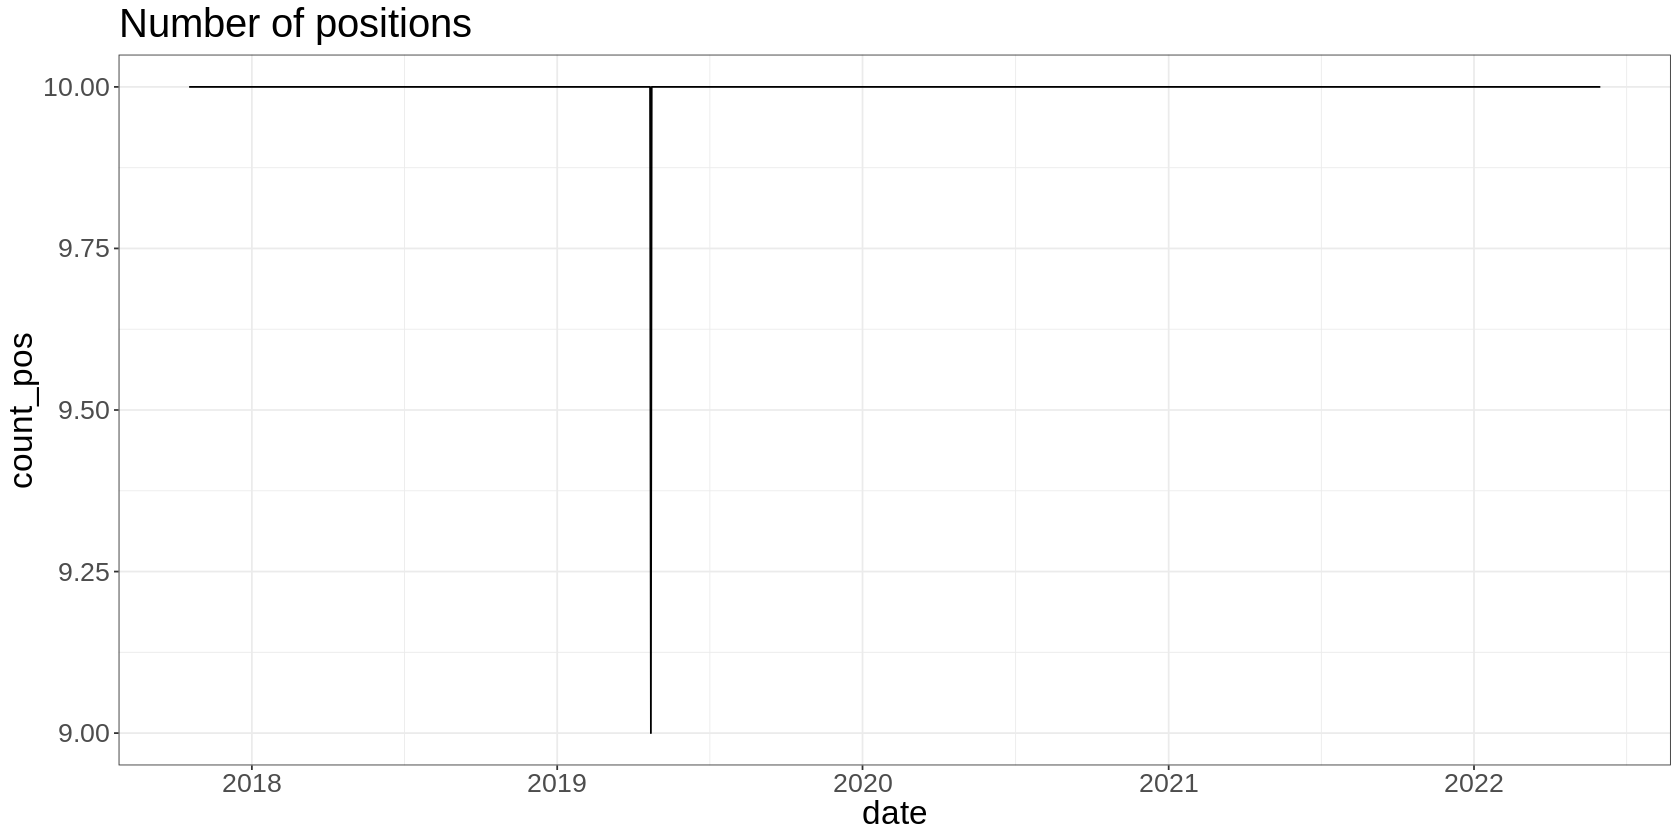

In [8]:
# check weights sum to 1
checks_df <- universe %>% 
  filter(date >= universe_start_date) %>% 
  select(ticker, date, price_usd, is_index, momo20) %>% 
  # can't filter on is_index because we need price on day after it drops out of index
  # instead, replace momo values with NA if not in index then rank each day
  mutate(universe_momo20 = case_when(is_index == TRUE ~ momo20, TRUE ~ NA_real_)) %>%
  group_by(date) %>%
  mutate(
    rank = row_number(universe_momo20),
    weight = rank - mean(rank, na.rm = TRUE),
    theo_weight = weight/(sum(abs(weight), na.rm = TRUE))
  ) %>% 
  select(ticker, date, price_usd, weight, theo_weight) 
  
checks_df %>%
  summarise(total_weight = sum(abs(theo_weight), na.rm = TRUE)) %>%
  ggplot(aes(x = date, y = total_weight)) +
    geom_line() +
    labs(
      title = "Sum of absolute weights"
    )

checks_df %>%
  summarise(
    min_weight = min(theo_weight, na.rm = TRUE), 
    max_weight = max(theo_weight, na.rm = TRUE)
  ) %>%
  pivot_longer(-date, names_to = "type", values_to = "weight") %>%
  ggplot(aes(x = date, y = weight, colour = type)) +
    geom_line() +
    labs(
      title = "Max and min weights"
    )

checks_df %>%
  summarise(
    count_pos = sum(!is.na(theo_weight))
  ) %>%
  ggplot(aes(x = date, y = count_pos)) +
    geom_line() +
    labs(
      title = "Number of positions"
    )

Our weights always sum to 1. The max and min weights hover around +/-0.18 and only change when the size of our tradable index decreases. 

However, sometimes we have only 9 positions. Why?

Sometimes, the size of our tradable universe decreases:

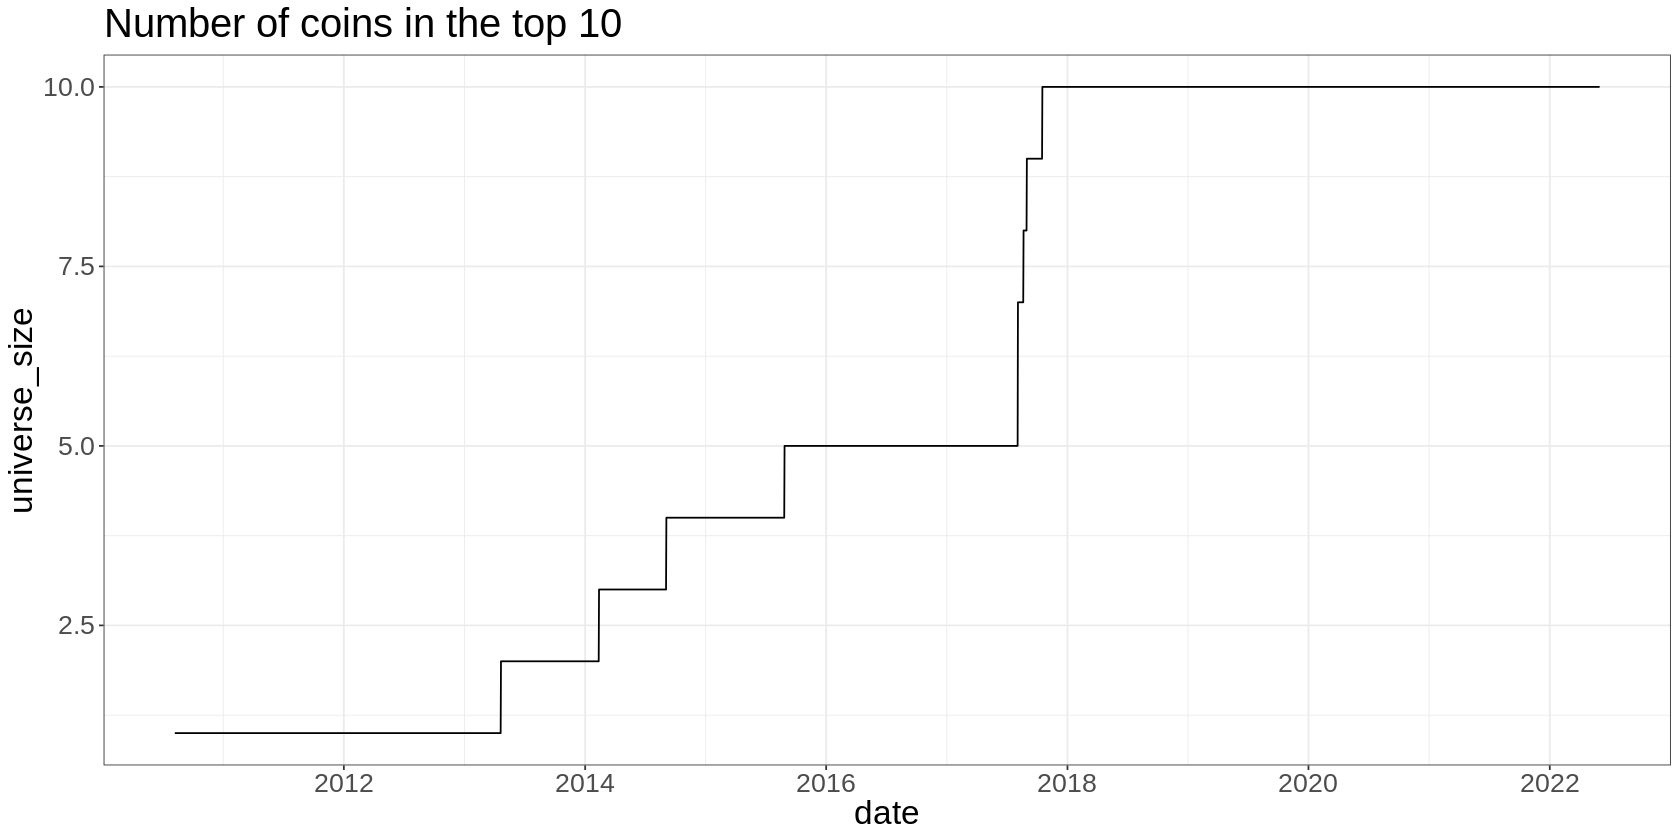

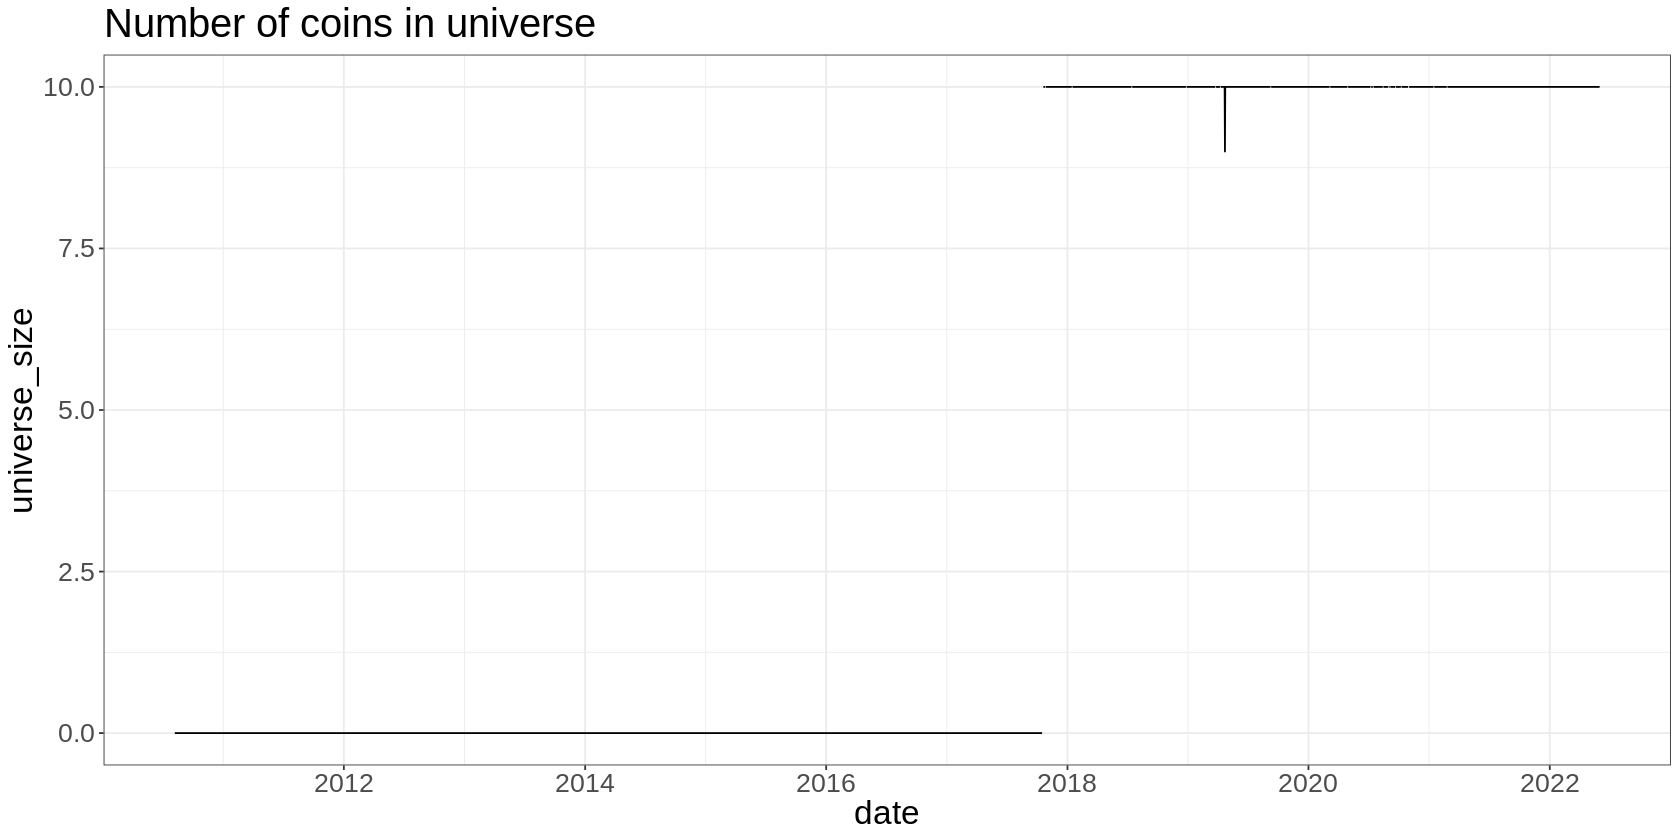

In [9]:
universe %>%
  group_by(date) %>%
  summarise(universe_size = sum(cap_rank <= 10)) %>%
  ggplot(aes(x = date, y = universe_size)) +
    geom_line() +
    labs(
      title = "Number of coins in the top 10"
    )

universe %>%
  group_by(date) %>%
  summarise(universe_size = sum(is_index)) %>%
  ggplot(aes(x = date, y = universe_size)) +
    geom_line() +
    labs(
      title = "Number of coins in universe"
    )

After our start date, we always have ten coins in the top 10 - we haven't lost any data (eg by premature `na.omit()`).

Occassionally, the number of coins in our universe decreases though. This happens when something in yesterday's top 10 ceases to exist. Let's look at all four cases.

First, the dates where we have less than 10 in our universe:

In [10]:
universe %>%
  group_by(date) %>%
  summarise(universe_size = sum(is_index)) %>%
  filter(universe_size < 10, date >= universe_start_date)

date,universe_size
<date>,<int>
2019-04-23,9


2018-06-03

In [11]:
# how does our universe and top 10 by market cap look the day before?
universe %>%
  filter(date == "2018-06-02", is_index == TRUE | cap_rank <= 10) 

# how does it look the day after?
universe %>%
  filter(date == "2018-06-03", is_index == TRUE | cap_rank <= 10)
# EOS_ETH is missing. 

# Does it exist after this date in our dataset?
universe %>%
  filter(date >= "2018-06-03", ticker == "EOS_ETH")

ticker,date,price_usd,market_cap,momo20,cap_rank,is_index
<chr>,<date>,<dbl>,<dbl>,<dbl>,<int>,<lgl>
BAT,2018-06-02,0.2999196,449879441,-0.2411363,10,TRUE
BCH,2018-06-02,1082.0853963,18570883149,-0.2687189,4,TRUE
BNB,2018-06-02,14.6573808,2857779843,0.1172815,6,TRUE
BTC,2018-06-02,7637.4482531,130378486454,-0.1217117,1,TRUE
ETH,2018-06-02,591.8119591,59081309627,-0.1908801,3,TRUE
LTC,2018-06-02,123.3173694,7005904323,-0.1476874,5,TRUE
MKR,2018-06-02,797.2694883,797269488,-0.1938624,9,TRUE
OMG,2018-06-02,11.5462283,1619305387,-0.1927043,7,TRUE
XRP,2018-06-02,0.6427624,64271029213,-0.1249735,2,TRUE


ticker,date,price_usd,market_cap,momo20,cap_rank,is_index
<chr>,<date>,<dbl>,<dbl>,<dbl>,<int>,<lgl>
BAT,2018-06-03,0.3030586,454587920,-0.25530777,10,TRUE
BCH,2018-06-03,1165.9459537,20012265386,-0.17892650,4,TRUE
BNB,2018-06-03,14.5826844,2843216141,0.13383593,6,TRUE
BTC,2018-06-03,7702.1579331,131498835221,-0.11174120,1,TRUE
ETH,2018-06-03,618.2328428,61731602955,-0.14893408,3,TRUE
LTC,2018-06-03,125.0264936,7104775310,-0.15177532,5,TRUE
MKR,2018-06-03,815.8847250,815884725,-0.14569438,9,TRUE
OMG,2018-06-03,11.7714455,1650891066,-0.16907382,7,TRUE
XRP,2018-06-03,0.6745512,67449649186,-0.07477161,2,TRUE


ticker,date,price_usd,market_cap,momo20,cap_rank,is_index
<chr>,<date>,<dbl>,<dbl>,<dbl>,<int>,<lgl>


It appears that EOS_ETH ceased to exist on 2018-06-03. Not sure what this is - consider reomving from dataset altogether.

2018-06-26:

In [12]:
# how does our universe and top 10 by market cap look the day before?
universe %>%
  filter(date == "2018-06-25", is_index == TRUE | cap_rank <= 10) 

# how does it look the day after?
universe %>%
  filter(date == "2018-06-26", is_index == TRUE | cap_rank <= 10)
# TRX_ETH is missing. 

# Does it exist after this date in our dataset?
universe %>%
  filter(date >= "2018-06-26", ticker == "TRX_ETH")

ticker,date,price_usd,market_cap,momo20,cap_rank,is_index
<chr>,<date>,<dbl>,<dbl>,<dbl>,<int>,<lgl>
BAT,2018-06-25,0.2531018,379652712,-0.09998949,10,TRUE
BCH,2018-06-25,755.2731958,12993294043,-0.34068459,4,TRUE
BNB,2018-06-25,14.8539801,2896111210,-0.04630599,6,TRUE
BTC,2018-06-25,6243.5354410,106861339066,-0.17968565,1,TRUE
ETH,2018-06-25,459.1942902,46059269148,-0.24372665,3,TRUE
LTC,2018-06-25,81.6371550,4665082421,-0.32984016,5,TRUE
MKR,2018-06-25,524.9055309,524905531,-0.36137291,9,TRUE
OMG,2018-06-25,7.8565167,1101840312,-0.30203613,7,TRUE
XRP,2018-06-25,0.4808427,48080353958,-0.28584912,2,TRUE


ticker,date,price_usd,market_cap,momo20,cap_rank,is_index
<chr>,<date>,<dbl>,<dbl>,<dbl>,<int>,<lgl>
BAT,2018-06-26,0.2310644,346596538,-0.1568523,10,TRUE
BCH,2018-06-26,704.2649268,12117017823,-0.3751607,4,TRUE
BNB,2018-06-26,13.9983224,2729281863,-0.1848470,6,TRUE
BTC,2018-06-26,6096.1287662,104349523004,-0.2032012,1,TRUE
ETH,2018-06-26,432.4930815,43389943766,-0.2856425,3,TRUE
LTC,2018-06-26,76.2311700,4357185633,-0.3712249,5,TRUE
MKR,2018-06-26,493.0579368,493057937,-0.3829563,9,TRUE
OMG,2018-06-26,7.2750269,1020289048,-0.3430268,7,TRUE
XRP,2018-06-26,0.4566500,45661284647,-0.3205610,2,TRUE


ticker,date,price_usd,market_cap,momo20,cap_rank,is_index
<chr>,<date>,<dbl>,<dbl>,<dbl>,<int>,<lgl>


It appears that TRX_ETH ceased to exist on 2018-06-26. Not sure what this is - consider reomving from dataset altogether.

2019-04-23:

In [13]:
# how does our universe and top 10 by market cap look the day before?
universe %>%
  filter(date == "2019-03-22", is_index == TRUE | cap_rank <= 10) 

# how does it look the day after?
universe %>%
  filter(date == "2019-04-23", is_index == TRUE | cap_rank <= 10)
# BNB is missing. 

# Does it exist after this date in our dataset?
universe %>%
  filter(date >= "2019-04-23", ticker == "BNB")

ticker,date,price_usd,market_cap,momo20,cap_rank,is_index
<chr>,<date>,<dbl>,<dbl>,<dbl>,<int>,<lgl>
BAT,2019-03-22,1.972272e-01,295840728,0.110197051,10,TRUE
BCH,2019-03-22,1.563556e+02,2765453669,0.202288317,6,TRUE
BNB,2019-03-22,1.514928e+01,2865873300,0.292578714,5,TRUE
BTC,2019-03-22,3.983888e+03,70133970901,0.045737681,1,TRUE
ETH,2019-03-22,1.358934e+02,14316051500,0.027958744,3,TRUE
LINK,2019-03-22,4.622572e-01,462257238,0.095512212,9,TRUE
LTC,2019-03-22,5.921129e+01,3613282779,0.225534953,4,TRUE
MKR,2019-03-22,7.283776e+02,728377608,0.073192372,8,TRUE
TRX,2019-03-22,2.251265e-02,2251264703,-0.004016091,7,TRUE


ticker,date,price_usd,market_cap,momo20,cap_rank,is_index
<chr>,<date>,<dbl>,<dbl>,<dbl>,<int>,<lgl>
BAT,2019-04-23,4.239752e-01,635962768,0.48688259,9,FALSE
BCH,2019-04-23,2.904935e+02,5154687166,-0.02008332,5,TRUE
BTC,2019-04-23,5.544863e+03,97931104713,0.11786457,1,TRUE
CRO,2019-04-23,7.800588e-02,7800587950,0.65884062,4,TRUE
ETH,2019-04-23,1.709374e+02,18082477241,0.06676152,3,TRUE
HT,2019-04-23,2.424167e+00,1212083703,-0.11029577,8,TRUE
LTC,2019-04-23,7.488290e+01,4604827924,-0.11180337,6,TRUE
MKR,2019-04-23,6.005805e+02,600580466,-0.19104796,10,TRUE
TRX,2019-04-23,2.432807e-02,2432806698,-0.06361555,7,TRUE


ticker,date,price_usd,market_cap,momo20,cap_rank,is_index
<chr>,<date>,<dbl>,<dbl>,<dbl>,<int>,<lgl>


It appears that BNB ceased to exist on 2019-04-23 - which is odd, because it still exists, just not in our data set.

2021-07-04:

In [14]:
# how does our universe and top 10 by market cap look the day before?
universe %>%
  filter(date == "2021-07-03", is_index == TRUE | cap_rank <= 10) 

# how does it look the day after?
universe %>%
  filter(date == "2021-07-04", is_index == TRUE | cap_rank <= 10)
# BNB_BC is missing. 

# Does it exist after this date in our dataset?
universe %>%
  filter(date >= "2021-07-04", ticker == "BNB_BC")

ticker,date,price_usd,market_cap,momo20,cap_rank,is_index
<chr>,<date>,<dbl>,<dbl>,<dbl>,<int>,<lgl>
BCH,2021-07-03,5.032561e+02,9451075367,-0.17871606,9,TRUE
BTC,2021-07-03,3.458822e+04,648430198161,-0.11142321,1,TRUE
CRO,2021-07-03,1.177283e-01,11772829531,-0.01750943,7,TRUE
DOGE,2021-07-03,2.455194e-01,31954087153,-0.24041636,4,TRUE
ETH,2021-07-03,2.215903e+03,258259687590,-0.11528300,2,TRUE
FTT,2021-07-03,2.793234e+01,9432620918,-0.14653614,10,TRUE
LINK,2021-07-03,1.844504e+01,18445044621,-0.20866869,6,TRUE
LTC,2021-07-03,1.395960e+02,9492619943,-0.18156985,8,TRUE
UNI,2021-07-03,1.924715e+01,19247145729,-0.17042000,5,TRUE


ticker,date,price_usd,market_cap,momo20,cap_rank,is_index
<chr>,<date>,<dbl>,<dbl>,<dbl>,<int>,<lgl>
BCH,2021-07-04,5.288574e+02,9932212193,-0.17132590,8,TRUE
BTC,2021-07-04,3.535561e+04,662841855840,-0.12606385,1,TRUE
CRO,2021-07-04,1.225071e-01,12250709868,0.02831756,7,TRUE
DOGE,2021-07-04,2.466909e-01,32109924540,-0.24664748,4,TRUE
ETH,2021-07-04,2.325917e+03,271112949444,-0.09744776,2,TRUE
FTT,2021-07-04,2.753355e+01,9297953270,-0.18621137,10,TRUE
LINK,2021-07-04,1.931356e+01,19313562553,-0.22231381,6,TRUE
LTC,2021-07-04,1.452271e+02,9876704766,-0.18753656,9,TRUE
UNI,2021-07-04,2.083349e+01,20833490889,-0.13477545,5,TRUE


ticker,date,price_usd,market_cap,momo20,cap_rank,is_index
<chr>,<date>,<dbl>,<dbl>,<dbl>,<int>,<lgl>


It appears that BNB_BC ceased to exist on 2021-07-04 - not sure what this is - consider reomving from dataset altogether.

We have four coins that disappeared from our dataset while they were in our universe. We might consider removing at least three of these from the dataset altogether. BNB is a coin that still exists, but disappeared abruptly from the dataset. 

We'll come back to this. For now, it won't make a huge difference.

### Get weights and prices as matrixes for simulation

In [15]:
# get weights as a wide matrix (could do equal weight, in proportion to factor/signal, top n etc)
# here we do proportional to factor rank and allow long-short
# note that date column will get converted to unix timestamp
# note that when our universe is young, we might not have 10 tradables since we need some lookback period to calculate the first factor value for the tenth asset.
backtest_theo_weights <- backtest_df %>% 
  select(date, starts_with("theo_weight_")) %>% 
  data.matrix()

# NA weights should be zero
backtest_theo_weights[is.na(backtest_theo_weights)] <- 0

head(backtest_theo_weights)

# get prices as a wide matrix
# note that date column will get converted to unix timestamp
backtest_prices <- backtest_df %>% 
  select(date, starts_with("price_")) %>% 
  data.matrix()

head(backtest_prices)

date,theo_weight_BCH,theo_weight_BNB,theo_weight_BTC,theo_weight_DOGE,theo_weight_ETH,theo_weight_KNC,theo_weight_LTC,theo_weight_OMG,theo_weight_XRP,⋯,theo_weight_BAL,theo_weight_YFI,theo_weight_SRM,theo_weight_CRV,theo_weight_SUSHI,theo_weight_UNI,theo_weight_AAVE,theo_weight_ALPHA,theo_weight_1INCH,theo_weight_PERP
17457,-0.14,-0.02,0.18,-0.06,0.06,-0.18,0.14,-0.10,0.10,⋯,0,0,0,0,0,0,0,0,0,0
17458,-0.14,-0.02,0.18,-0.06,0.02,-0.18,0.14,-0.10,0.10,⋯,0,0,0,0,0,0,0,0,0,0
17459,-0.06,-0.02,0.18,0.00,0.06,-0.14,0.14,-0.10,0.10,⋯,0,0,0,0,0,0,0,0,0,0
17460,-0.06,-0.02,0.18,0.00,0.06,-0.18,0.14,-0.10,0.10,⋯,0,0,0,0,0,0,0,0,0,0
17461,-0.06,-0.14,0.18,0.00,0.06,-0.18,0.14,-0.02,0.02,⋯,0,0,0,0,0,0,0,0,0,0
17462,-0.06,-0.14,0.18,0.00,0.06,-0.18,0.14,-0.02,0.02,⋯,0,0,0,0,0,0,0,0,0,0


date,price_usd_BCH,price_usd_BNB,price_usd_BTC,price_usd_DOGE,price_usd_ETH,price_usd_KNC,price_usd_LTC,price_usd_OMG,price_usd_XRP,⋯,price_usd_BAL,price_usd_YFI,price_usd_SRM,price_usd_CRV,price_usd_SUSHI,price_usd_UNI,price_usd_AAVE,price_usd_ALPHA,price_usd_1INCH,price_usd_PERP
17457,338.7678,1.317849,5583.870,0.0010289347,313.2929,1.162461,60.69765,7.854567,0.2180179,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
17458,329.9444,1.286488,5708.313,0.0010451067,308.3612,1.114841,59.78077,7.827557,0.2137977,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
17459,327.3707,1.240682,6000.883,0.0010452918,304.1048,1.044030,60.26844,7.305775,0.2075473,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
17460,322.5177,1.233071,6030.208,0.0009986687,299.9645,1.025443,58.05432,7.405425,0.2081025,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
17461,330.7723,1.215623,5996.598,0.0010439447,294.8625,1.007951,56.64666,7.724162,0.2014042,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
17462,312.0320,1.181881,5888.250,0.0010124827,285.2723,0.957936,54.64016,7.693838,0.1936669,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


### Simulate

First, no costs:

In [16]:
# fees - reasonable approximation of actual costs (spread + market impact + commission)
fees <- tribble(
  ~tier, ~fee,
  0, 0.,  # use for cost-free simulations
  1, 0.001,
  2, 0.0015,
  3, 0.0020,
  4, 0.0025,
  5, 0.0030,
  6, 0.0035,
  7, 0.0040,
  8, 0.0005 
)

# simulation parameters
initial_cash <- 10000
capitalise_profits <- FALSE  # remain fully invested?
trade_buffer <- 0.
fee_tier <- 0.
commission_pct <- fees$fee[fees$tier==fee_tier]

# simulation
results_df <- cash_backtest(backtest_prices, backtest_theo_weights, trade_buffer, initial_cash, commission_pct, capitalise_profits)

head(results_df)

ticker,Date,Close,Position,Value,Trades,TradeValue,Commission
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Cash,2017-10-18,1.000000e+00,0.000000e+00,10000,0.000000e+00,NA,0
BCH,2017-10-18,3.387678e+02,-4.132624e+00,-1400,-4.132624e+00,-1400,0
BNB,2017-10-18,1.317849e+00,-1.517624e+02,-200,-1.517624e+02,-200,0
BTC,2017-10-18,5.583870e+03,3.223571e-01,1800,3.223571e-01,1800,0
DOGE,2017-10-18,1.028935e-03,-5.831274e+05,-600,-5.831274e+05,-600,0
ETH,2017-10-18,3.132929e+02,1.915141e+00,600,1.915141e+00,600,0


### Simulation results

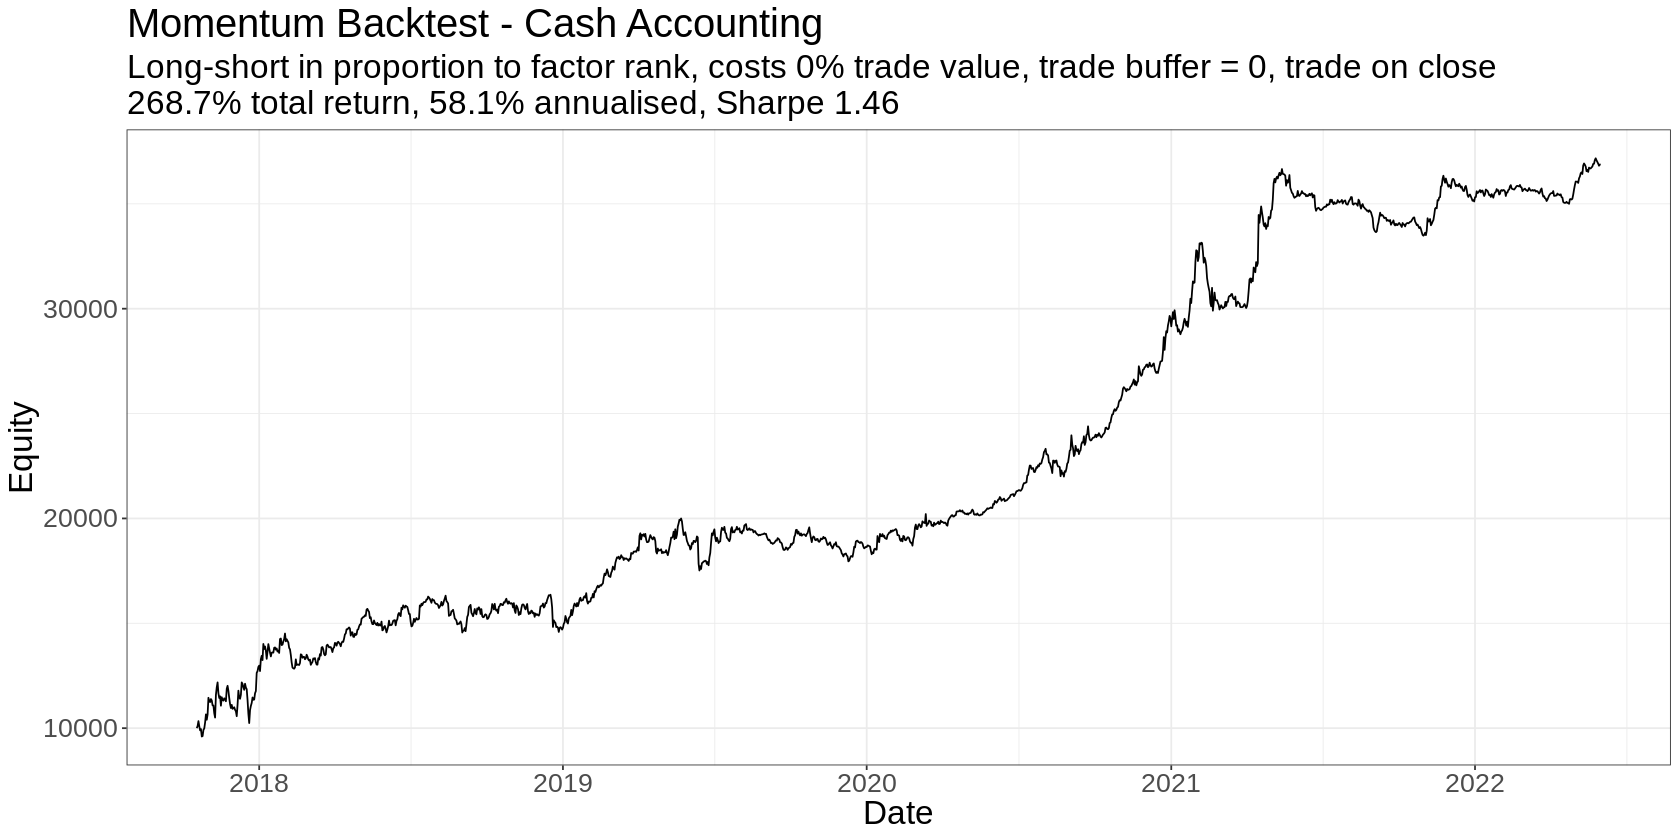

In [17]:
plot_results <- function(backtest_results, weighting_protocol = "Long-short in proportion to factor rank") {
  equity_curve <- backtest_results %>% 
    group_by(Date) %>% 
    summarise(Equity = sum(Value, na.rm = TRUE)) 

  fin_eq <- equity_curve %>% 
    tail(1) %>% 
    pull(Equity)

  init_eq <- equity_curve %>% 
    head(1) %>% 
    pull(Equity)

  total_return <- (fin_eq/init_eq - 1) * 100
  days <- nrow(equity_curve)
  ann_return <- total_return * 365/days
  sharpe <- equity_curve %>%
    mutate(returns = Equity/lag(Equity)- 1) %>%
    na.omit() %>%
    summarise(sharpe = sqrt(355)*mean(returns)/sd(returns)) %>%
    pull()

  equity_curve %>% 
    ggplot(aes(x = Date, y = Equity)) +
      geom_line() +
      labs(
        title = "Momentum Backtest - Cash Accounting",
        subtitle = glue(
          "{weighting_protocol}, costs {commission_pct*100}% trade value, trade buffer = {trade_buffer}, trade on close
          {round(total_return, 1)}% total return, {round(ann_return, 1)}% annualised, Sharpe {round(sharpe, 2)}"
        )
      ) 
}

plot_results(results_df)

Backtest with costs


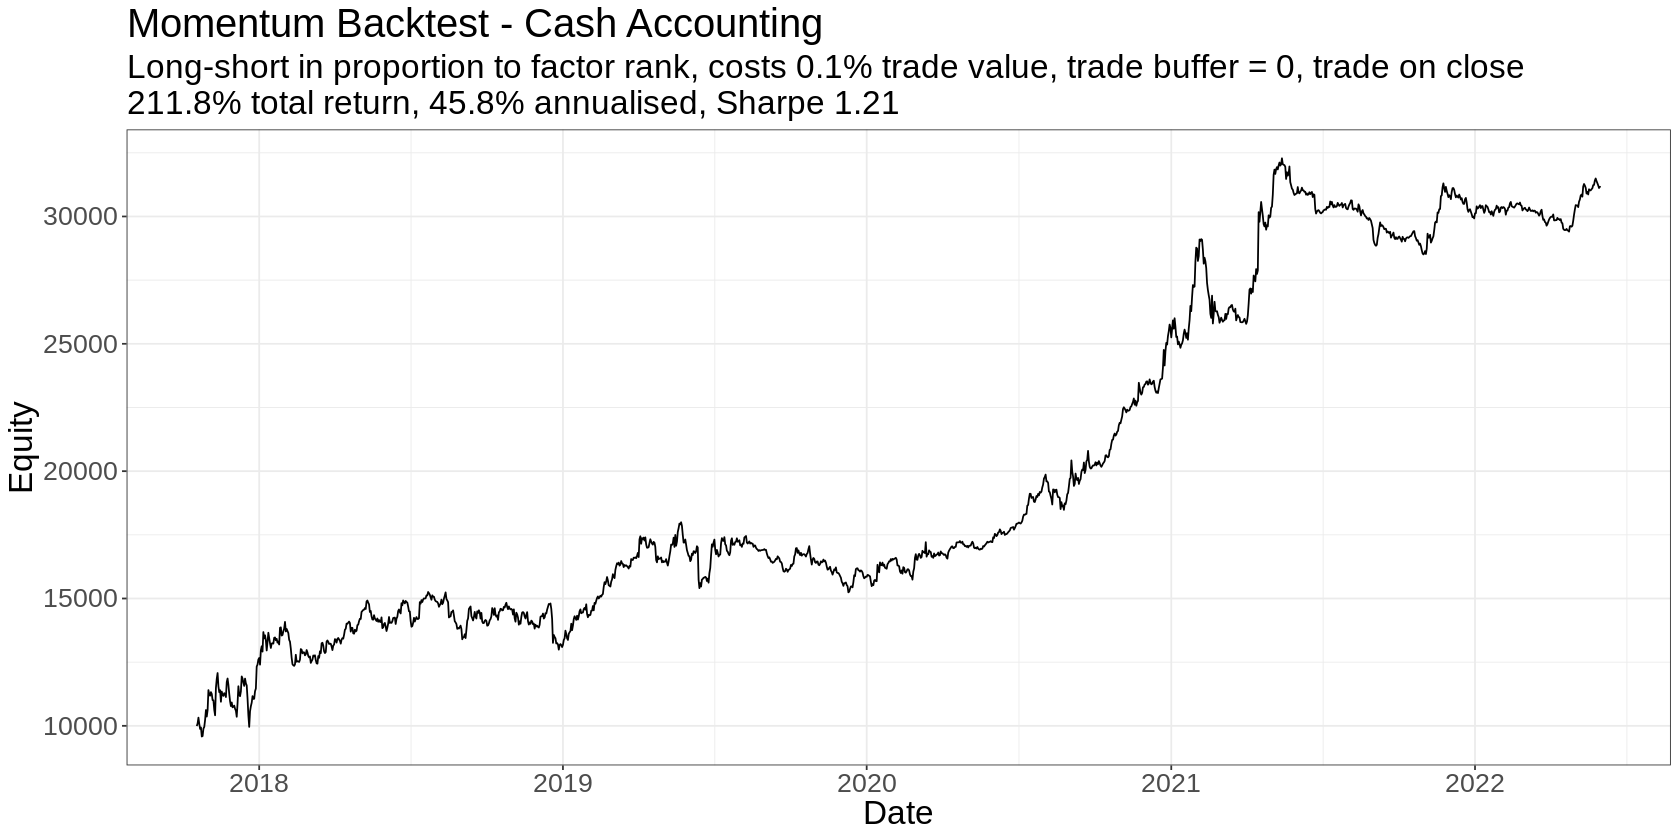

In [18]:
fee_tier <- 1
commission_pct <- fees$fee[fees$tier==fee_tier]

results_df <- cash_backtest(backtest_prices, backtest_theo_weights, trade_buffer, initial_cash, commission_pct, capitalise_profits)
plot_results(results_df)

### Trade buffer parameter

We don't always necessarily want to do trades according to our theoretical weights, for example if the cost to do the trade is large compared to expected returns. 

We use the concept of a "trade buffer". For each coin:
* If the current weight is less than the current theoretical weight less the trade buffer, we buy up to the current theoretical weight less the trade buffer.
* If the current weight is greater than the current theoretical weight plus the trade buffer, we sell down to the current theoretical weight plus the trade buffer.

*That is, we trade the bare minimum possible, up to the edge of our "trade buffer".*

We then tune the trade buffer parameter via simualtion.

Let's start by picking an arbitrary value:

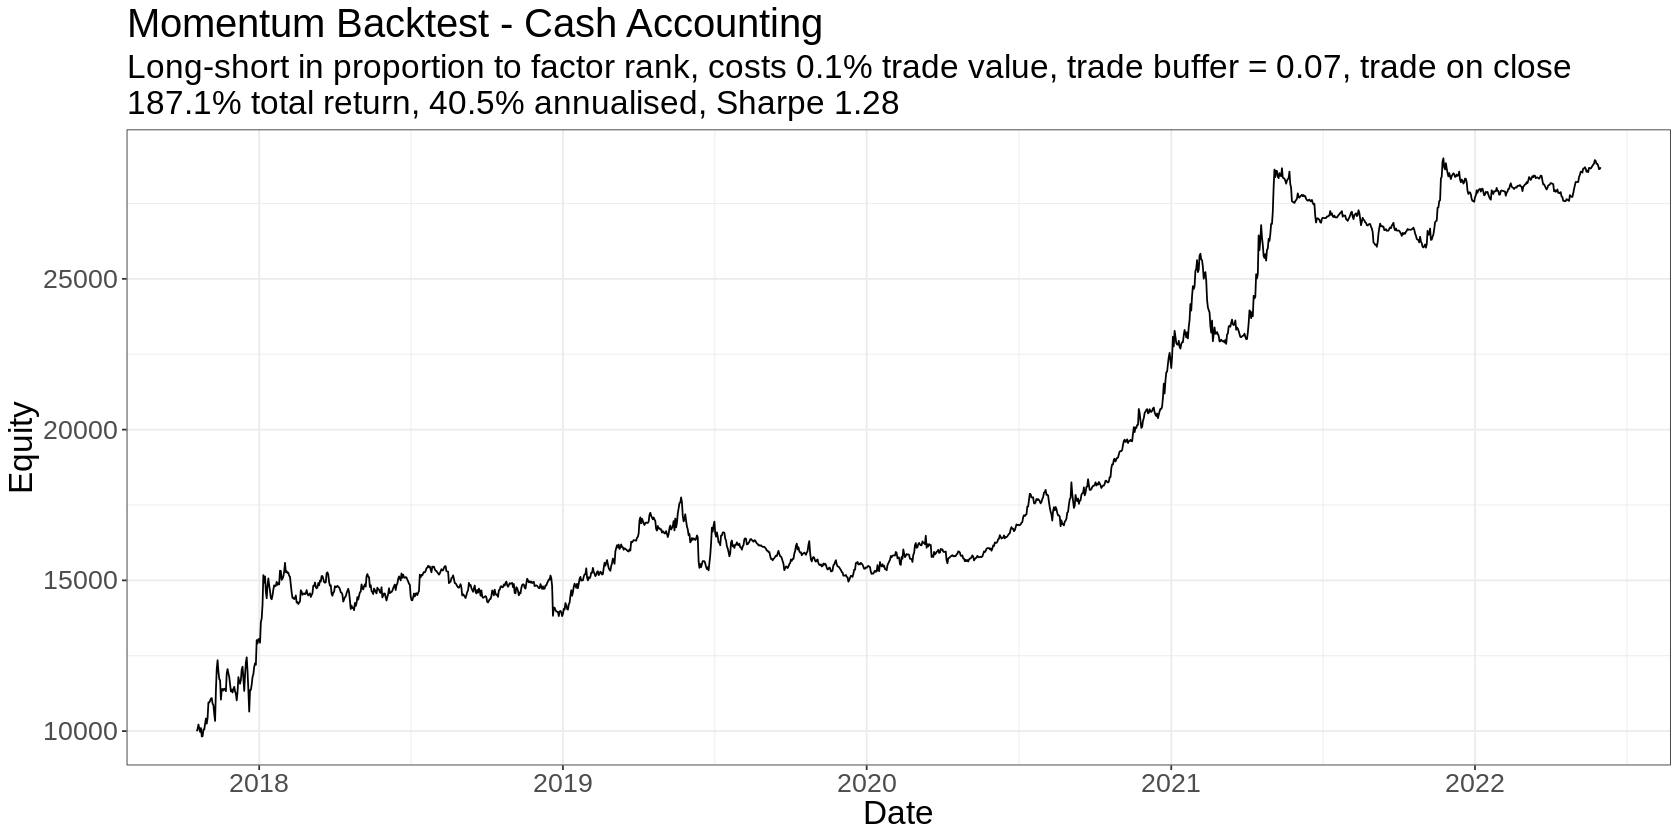

In [19]:
trade_buffer <- 0.07

results_df <- cash_backtest(backtest_prices, backtest_theo_weights, trade_buffer, initial_cash, commission_pct, capitalise_profits)
plot_results(results_df)

What's our historical Sharpe-optimal trade buffer parameter?

In [20]:
calc_sharpe <- function(backtest_results) {
  backtest_results %>% 
    group_by(Date) %>% 
    summarise(Equity = sum(Value, na.rm = TRUE)) %>%
    mutate(returns = Equity/lag(Equity)- 1) %>%
    na.omit() %>%
    summarise(sharpe = sqrt(355)*mean(returns)/sd(returns)) %>%
    pull()
}

sharpes <- list()
trade_buffers <- seq(0, 0.1, by = 0.005)
for(trade_buffer in trade_buffers) {
  sharpes <- c(
    sharpes, 
    cash_backtest(backtest_prices, backtest_theo_weights, trade_buffer, initial_cash, commission_pct, capitalise_profits) %>%
      calc_sharpe()
  )
}

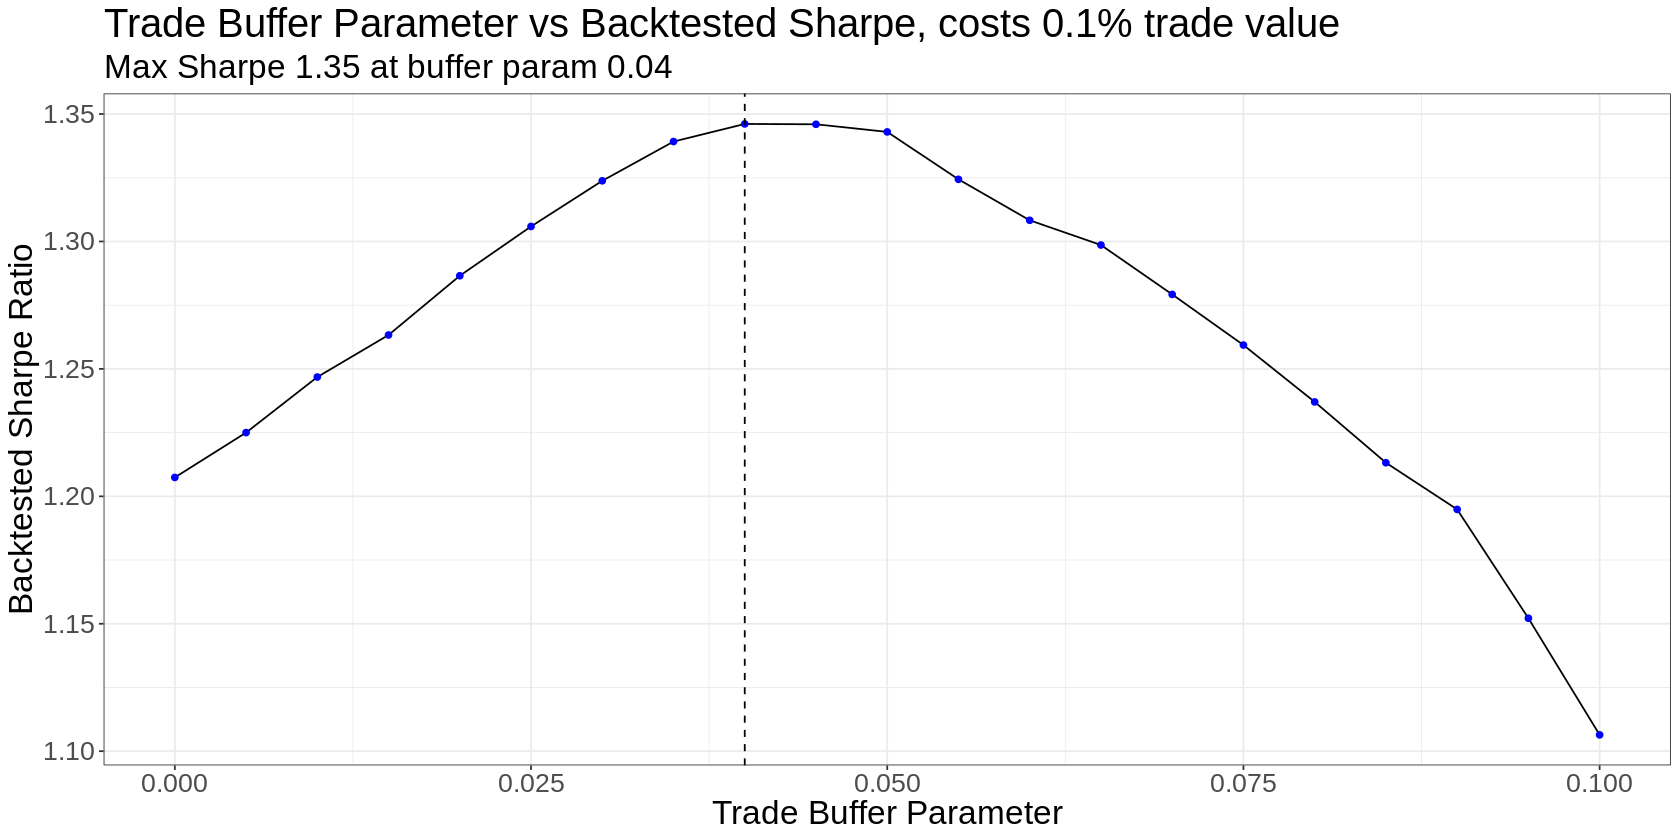

In [21]:
sharpes <- unlist(sharpes)
data.frame(
  trade_buffer = trade_buffers, 
  sharpe = sharpes
) %>%
  ggplot(aes(x = trade_buffer, y = sharpe)) +
    geom_line() +
    geom_point(colour = "blue") +
    geom_vline(xintercept = trade_buffers[which.max(sharpes)], linetype = "dashed") +
    labs(
      x = "Trade Buffer Parameter",
      y = "Backtested Sharpe Ratio",
      title = glue("Trade Buffer Parameter vs Backtested Sharpe, costs {commission_pct*100}% trade value"),
      subtitle = glue("Max Sharpe {round(max(sharpes), 2)} at buffer param {trade_buffers[which.max(sharpes)]}")
    )

Now let's backtest at our historically optimal trade buffer parameter:

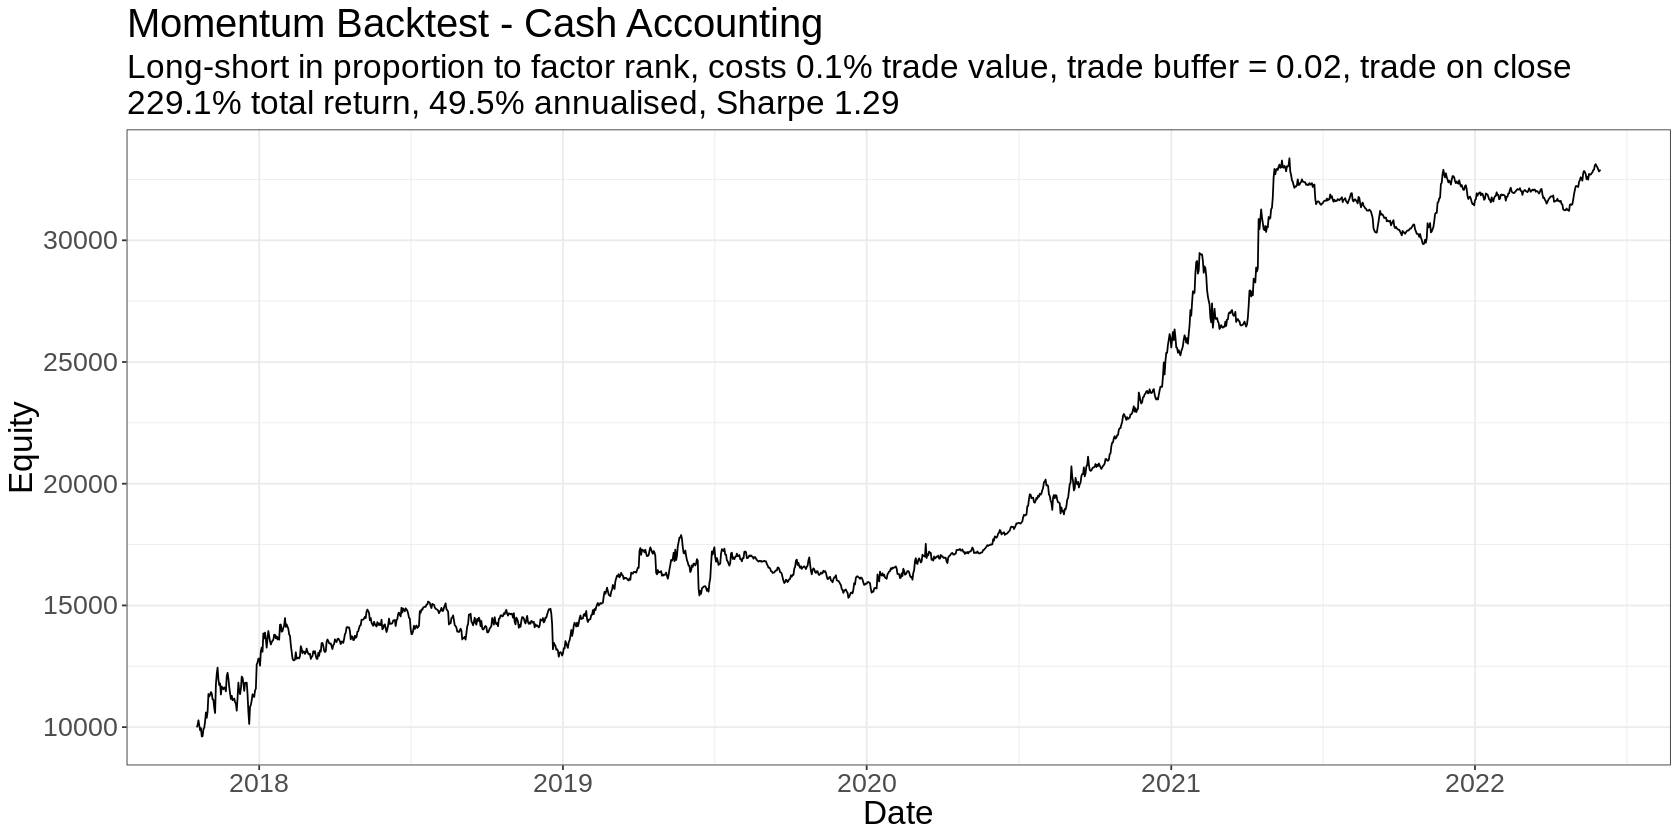

In [22]:
trade_buffer <- 0.02

results_df <- cash_backtest(backtest_prices, backtest_theo_weights, trade_buffer, initial_cash, commission_pct, capitalise_profits)
plot_results(results_df)

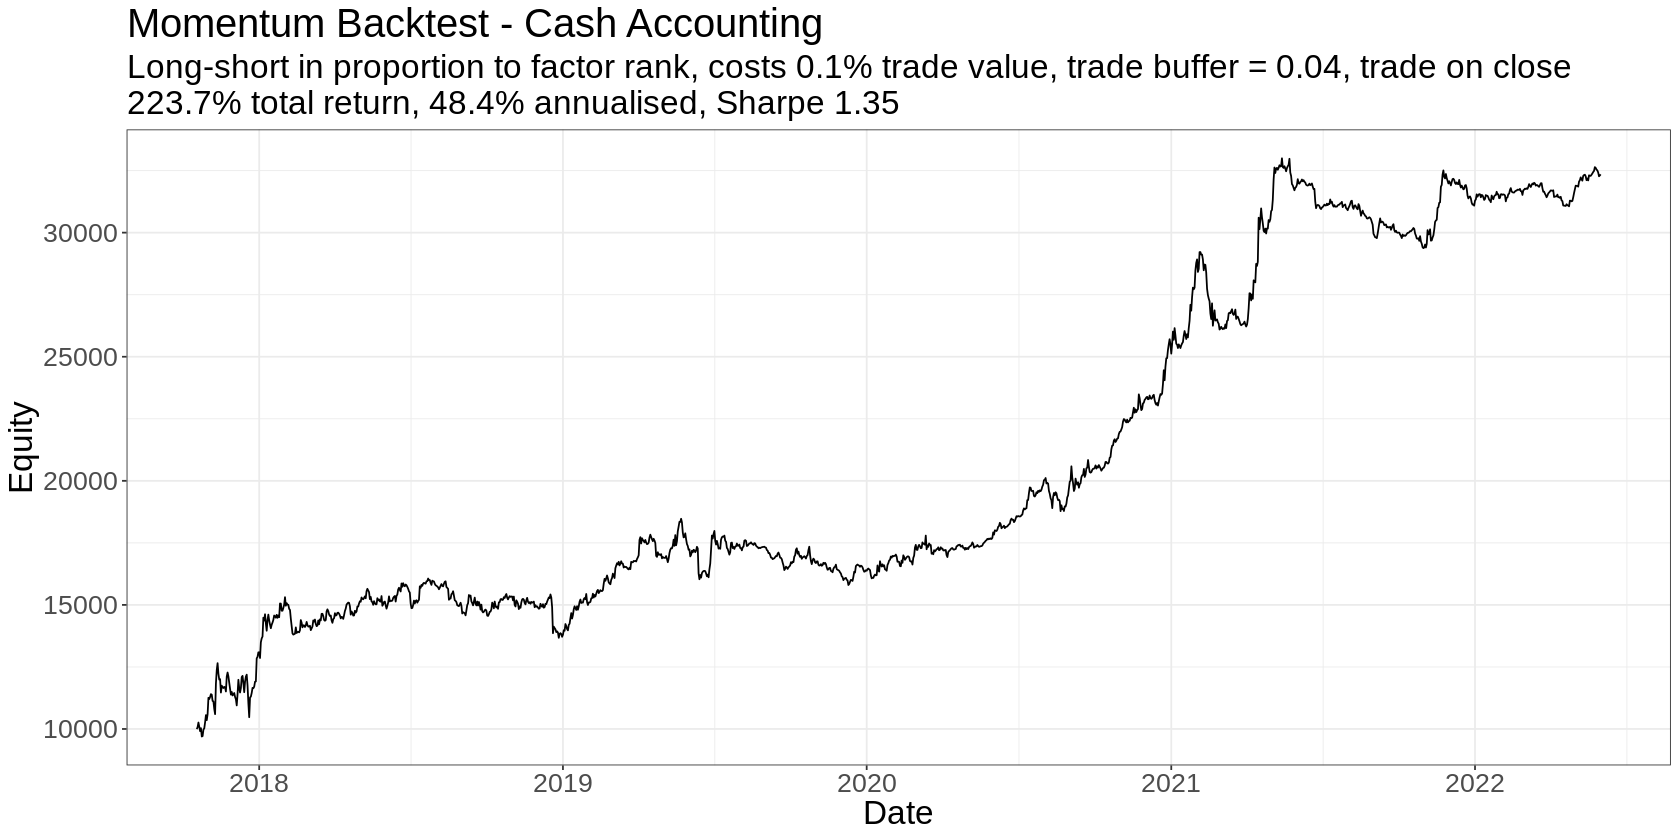

In [23]:
trade_buffer <- 0.04

results_df <- cash_backtest(backtest_prices, backtest_theo_weights, trade_buffer, initial_cash, commission_pct, capitalise_profits)

plot_results(results_df)

Let's get a feel for the historical daily turnover and costs of this approach:

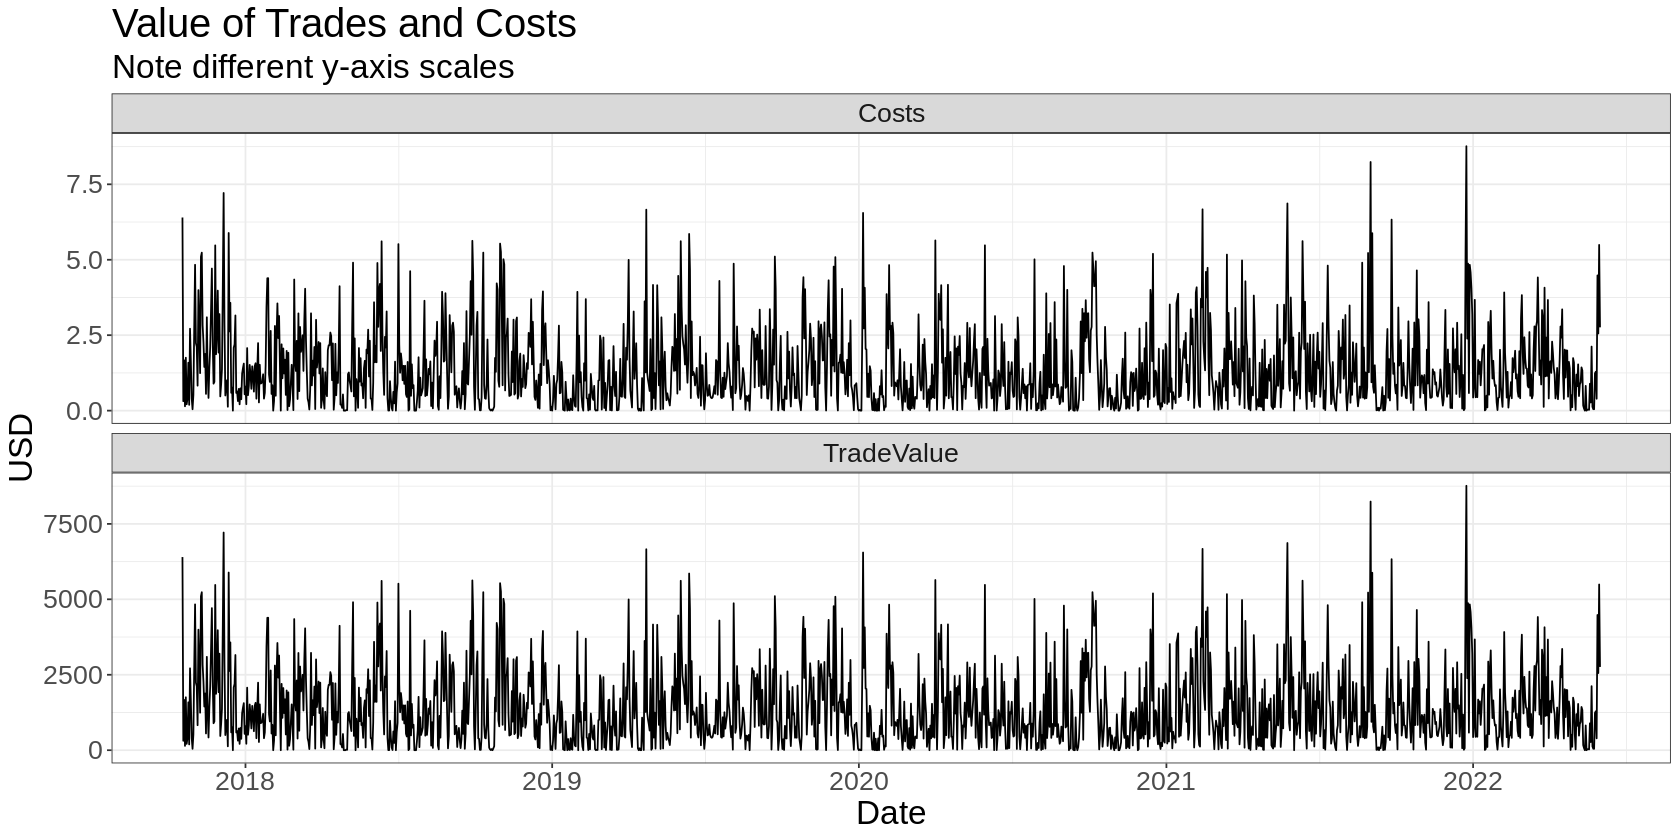

In [24]:
results_df %>%
  group_by(Date) %>%
  summarise(
    TradeValue = sum(abs(TradeValue), na.rm = TRUE),
    Costs = sum(Commission, na.rm = TRUE)
  ) %>%
  pivot_longer(-Date, names_to = "param", values_to = "value") %>%
  ggplot(aes(x = Date, y = value)) +
    geom_line() +
    facet_wrap(~param, ncol = 1, scales = "free_y") +
      labs(
        y = "USD",
        title = "Value of Trades and Costs",
        subtitle = "Note different y-axis scales"
      )

And how our exposures change over time:

Check traded value of inidividual coins:

Also check the edge case of when weight flips from positive to negative but remains inside trade buffer. I think we want to trade in that case?

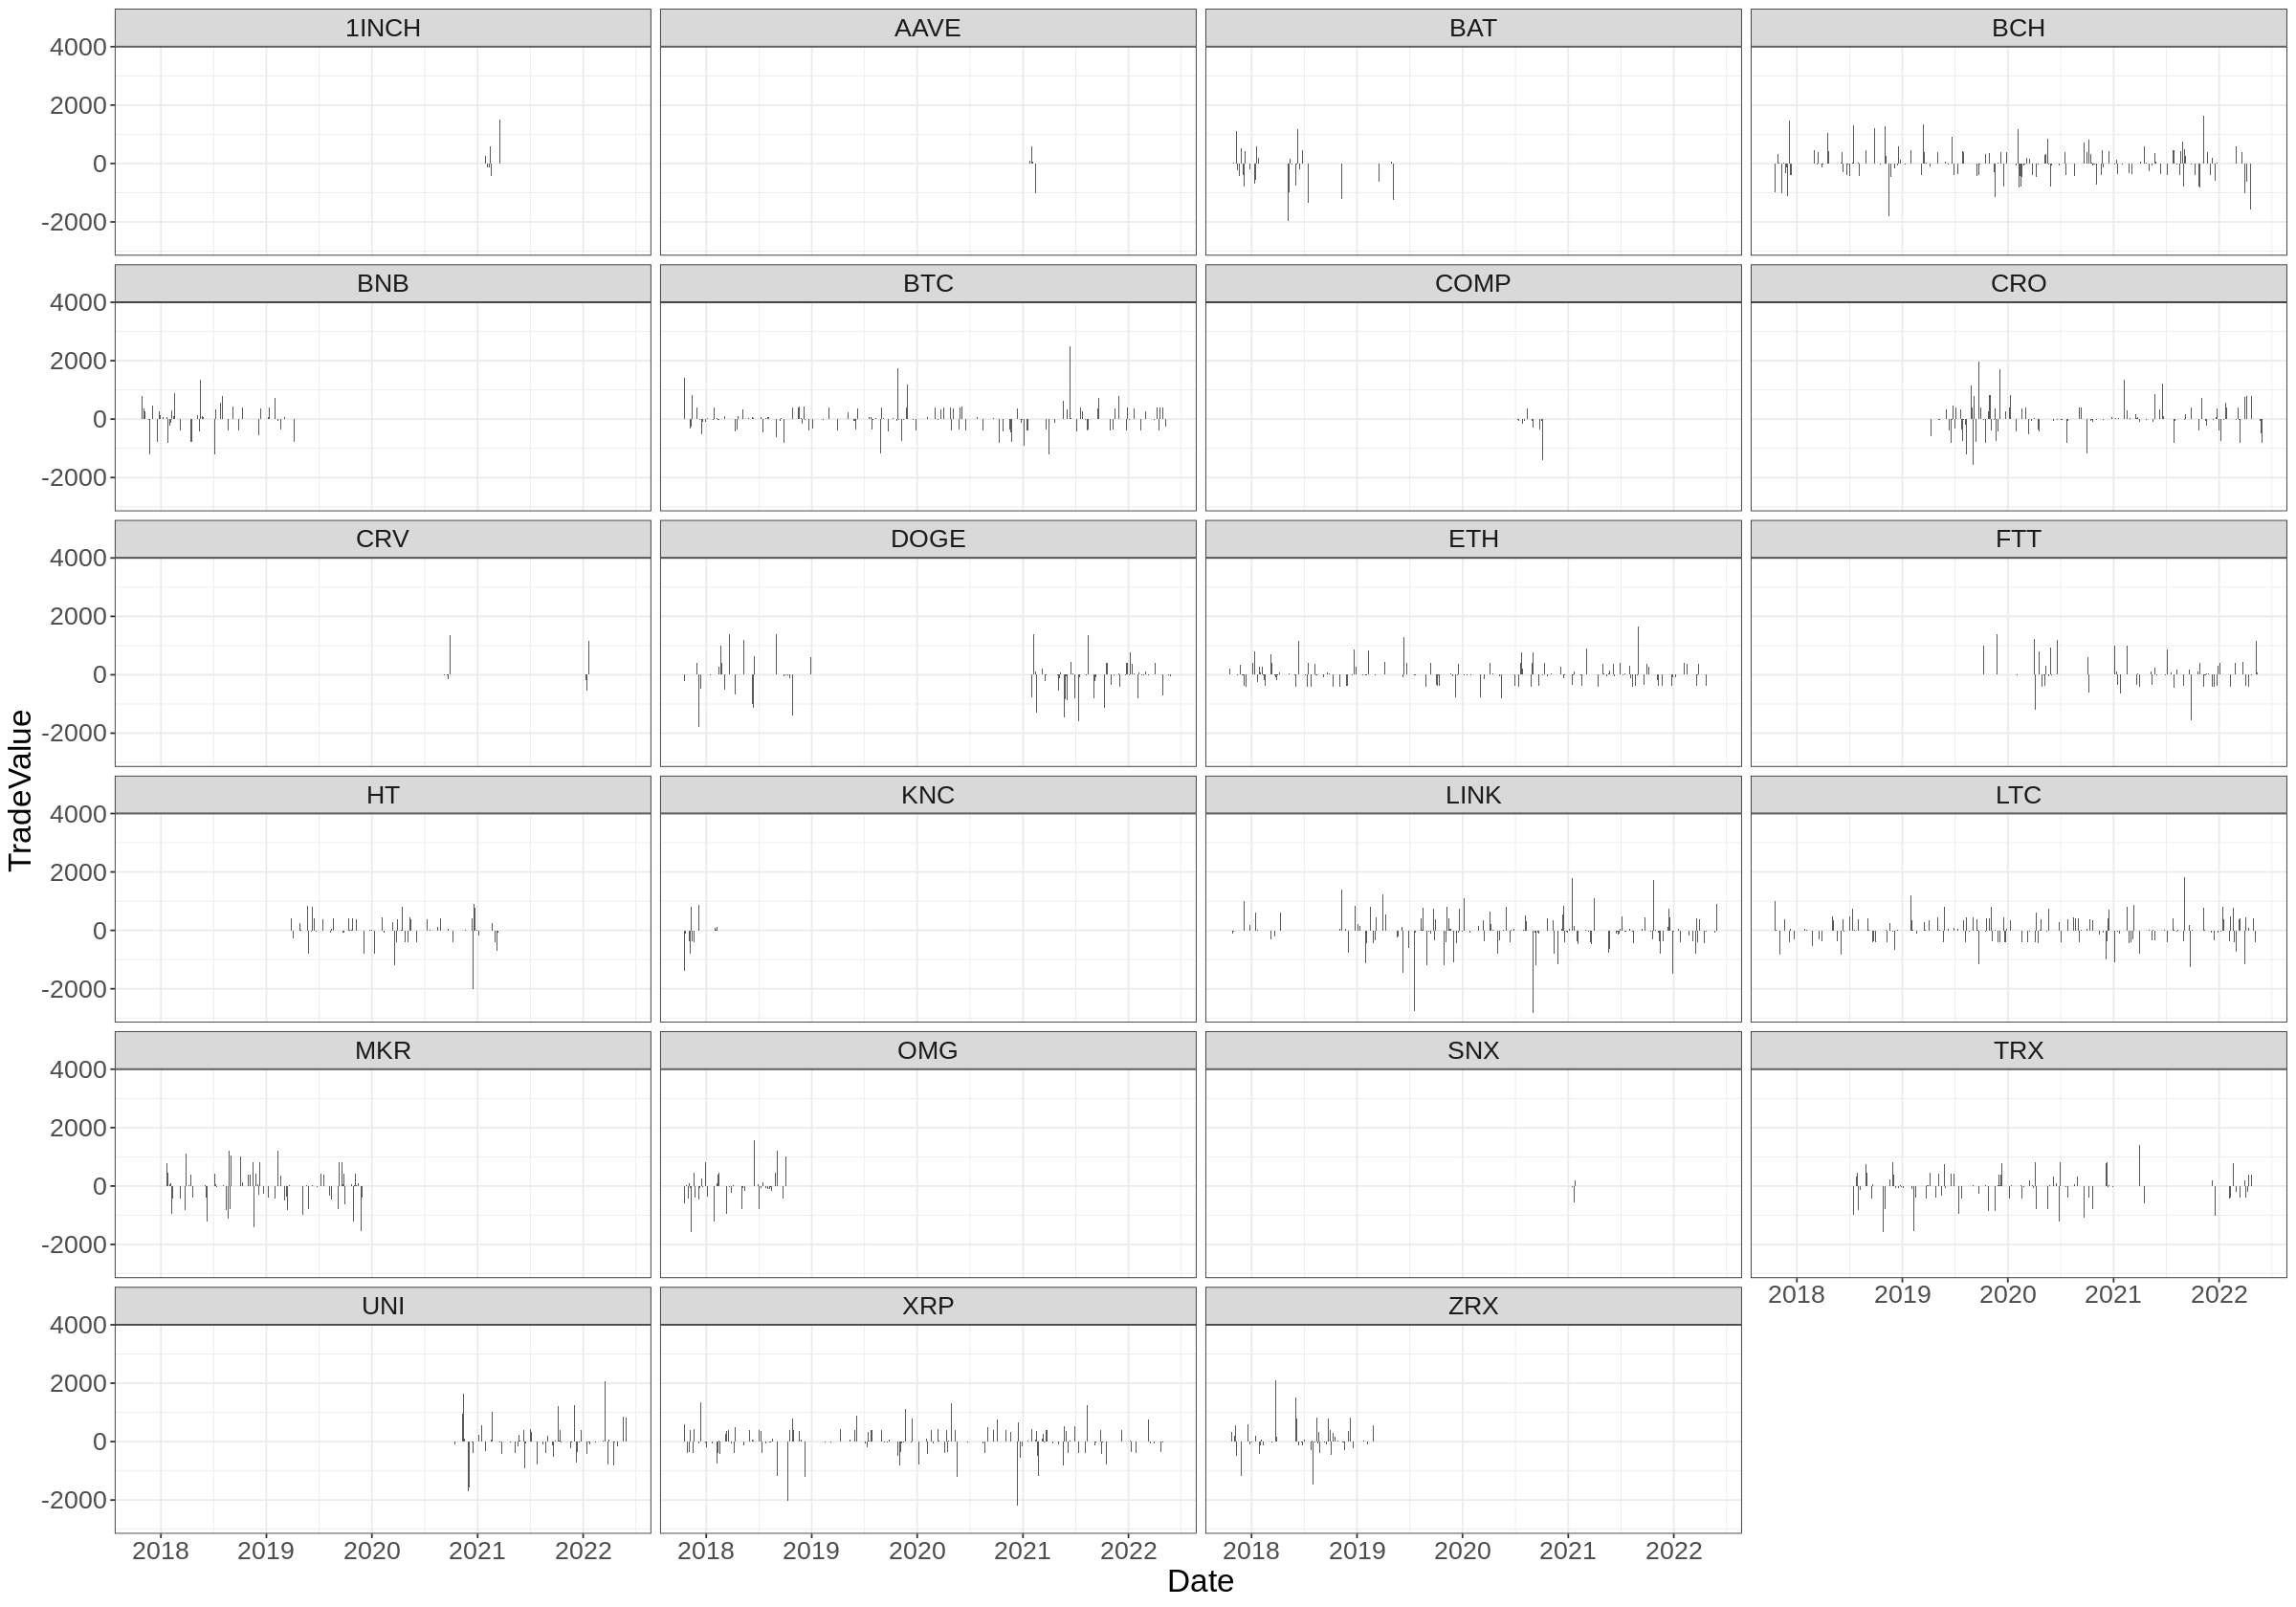

In [25]:
options(repr.plot.width = 20, repr.plot.height=14)

results_df %>%
  filter(ticker != "Cash", abs(TradeValue) > 0) %>%
  ggplot(aes(x = Date, y = TradeValue)) +
    geom_bar(stat = "identity") +
    facet_wrap(~ticker, ncol = 4)

# set back to default
options(repr.plot.width = 14, repr.plot.height=7)

Look at how much we turn over major coins:

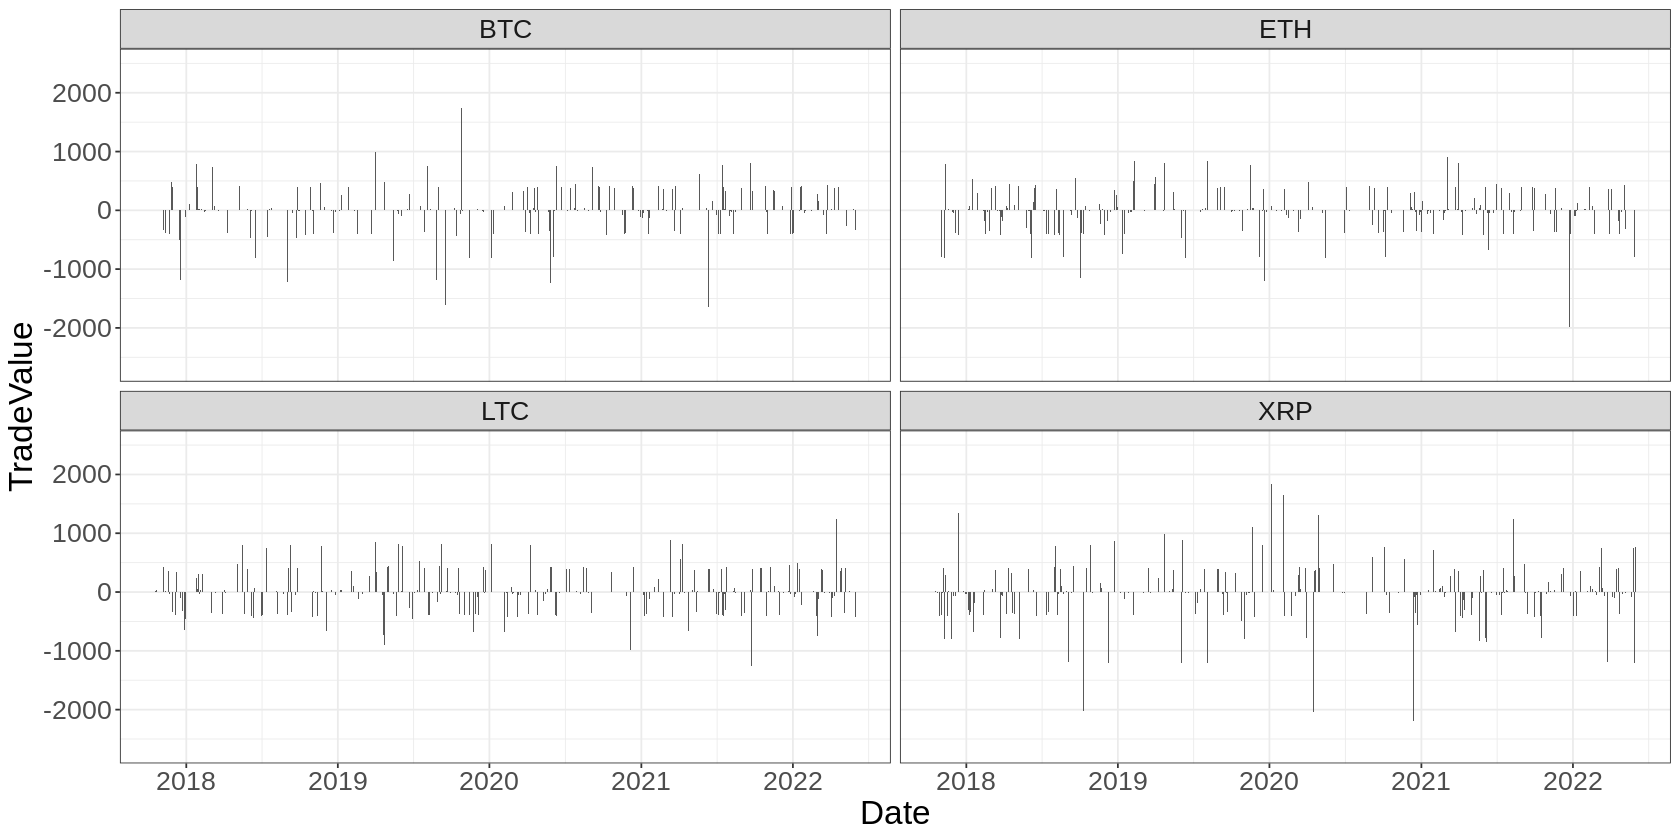

In [26]:
results_df %>%
  filter(ticker %in% c("BTC", "ETH", "LTC", "XLM", "XMR", "XRP")) %>%
  ggplot(aes(x = Date, y = TradeValue)) +
    geom_bar(stat = "identity") +
    facet_wrap(~ticker, ncol = 2)

It isn't insanely active, as we'd expect from our trade buffer parameter. However, there are some instances where it seems to flip position quite suddenly. May be worth looking into that. 

**TODO:** calculate turnover 

### Check backtest trades

First day of trading

In [27]:
trade_check_df <- backtest_df %>%
  filter(date == "2015-04-02") %>%
  select(date, starts_with("price")) %>%
  select(where(~sum(is.na(.x)) == 0)) %>%
  pivot_longer(-date, names_to = "coin", values_to = "price") %>%
  mutate(coin = stringr::str_remove(coin, "price_usd_")) %>%
  left_join(
    backtest_df %>%
      filter(date == "2015-04-02") %>%
      select(date, starts_with("theo")) %>%
      select(where(~sum(is.na(.x)) == 0)) %>%
      pivot_longer(-date, names_to = "coin", values_to = "theo_weight") %>%
      mutate(coin = stringr::str_remove(coin, "theo_weight_")),
    by = c("date", "coin")
  ) %>%
  mutate(
    trades = case_when(
      theo_weight > 0 ~ 10000*(theo_weight - trade_buffer)/price,
      theo_weight == 0 ~ 0,
      TRUE ~ 10000*(theo_weight + trade_buffer)/price
    )
  )

trade_check_df %>%
  left_join(results_df, by = c("date" = "Date", "coin" = "ticker")) %>%
  mutate(
    check_value_against_weight = Value == ifelse(
      theo_weight == 0, 
      0, 
      ifelse(
        theo_weight > 0, 
        (theo_weight - trade_buffer)*initial_cash, 
        (theo_weight + trade_buffer)*initial_cash
      )
    )
  )

date,coin,price,theo_weight,trades,Close,Position,Value,Trades,TradeValue,Commission,check_value_against_weight
<date>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>


A random day of trading

In [28]:
this_date <- "2018-04-23"

trade_check_df <- backtest_df %>%
  filter(date == this_date) %>%
  select(date, starts_with("price")) %>%
  select(where(~sum(is.na(.x)) == 0)) %>%
  pivot_longer(-date, names_to = "coin", values_to = "price") %>%
  mutate(coin = stringr::str_remove(coin, "price_usd_")) %>%
  left_join(
    backtest_df %>%
      filter(date == this_date) %>%
      select(date, starts_with("theo")) %>%
      select(where(~sum(is.na(.x)) == 0)) %>%
      pivot_longer(-date, names_to = "coin", values_to = "theo_weight") %>%
      mutate(coin = stringr::str_remove(coin, "theo_weight_")),
    by = c("date", "coin")
  ) %>%
  na.omit()

  # mutate(
  #   trades = case_when(
  #     theo_weight > 0 ~ 10000*(theo_weight - trade_buffer)/price,
  #     theo_weight == 0 ~ 0,
  #     TRUE ~ 10000*(theo_weight + trade_buffer)/price
  #   )
  # ) %>%
  # na.omit()

# join today's actual weights
trade_check_df %>%
  left_join(
    results_df %>%
      filter(Date == this_date) %>%
      na.omit() %>%
      mutate(
        actual_weight = Value/initial_cash
      ) %>%
      select(ticker, actual_weight),
    by = c("coin" = "ticker")
  ) %>%
  mutate(
    # is a trade expected tomorrow?
    trade_expected = case_when(
      theo_weight <= (actual_weight - trade_buffer) | theo_weight >= (actual_weight + trade_buffer) ~ TRUE,
      TRUE ~ FALSE
    ),
    # when we expect a change, is our final position as expceted? (easier to deal with than calculation expected trades)
    position_expected = case_when(
      theo_weight >= (actual_weight + trade_buffer) ~ 10000*(theo_weight - trade_buffer)/price,
      theo_weight <= (actual_weight - trade_buffer) ~ 10000*(theo_weight + trade_buffer)/price,
      TRUE ~ NA_real_  
    )
  ) %>%
  # join today's trades 
  left_join(
    results_df %>%
      filter(Date == this_date),
    by = c("date" = "Date", "coin" = "ticker")
  )

date,coin,price,theo_weight,actual_weight,trade_expected,position_expected,Close,Position,Value,Trades,TradeValue,Commission
<date>,<chr>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2018-04-23,BCH,1427.8662140,0.14,0.10000000,TRUE,0.7003457,1427.8662140,0.7003457,1000.0000,5.343737e-01,763.014209,0.763014209
2018-04-23,BNB,13.6171861,-0.18,-0.15413753,FALSE,NA,13.6171861,-113.1933773,-1541.3753,0.000000e+00,0.000000,0.000000000
2018-04-23,BTC,8930.7846335,-0.10,-0.14000000,TRUE,-0.1567611,8930.7846335,-0.1567611,-1400.0000,1.189278e-03,10.621187,0.010621187
2018-04-23,ETH,642.5817294,-0.06,-0.06804817,FALSE,NA,642.5817294,-1.0589808,-680.4817,0.000000e+00,0.000000,0.000000000
2018-04-23,LTC,152.0708059,-0.14,-0.13340297,FALSE,NA,152.0708059,-8.7724250,-1334.0297,0.000000e+00,0.000000,0.000000000
2018-04-23,OMG,15.8682950,0.02,0.06000000,FALSE,NA,15.8682950,37.8112456,600.0000,-1.718549e+00,-27.270448,0.027270448
2018-04-23,XRP,0.8750935,-0.02,0.02000000,TRUE,228.5470036,0.8750935,228.5470036,200.0000,-3.268124e+00,-2.859915,0.002859915
2018-04-23,ZRX,1.0044174,0.06,0.10000000,TRUE,995.6020675,1.0044174,995.6020675,1000.0000,-1.480724e+01,-14.872649,0.014872649
2018-04-23,BAT,0.4370001,0.18,0.14000000,TRUE,3203.6602818,0.4370001,3203.6602818,1400.0000,3.203660e+03,1400.000000,1.400000000


Where we expected a trade to happen, it happened and resulted in the correct final position. 

Note edge case in XLM - suspect rounding error in our checking vs backtest. 

**TODO:** 
* actual unit testing of simulation logic

## Long only backtest


In [29]:
# weight by rank long only
backtest_df <- universe %>% 
  filter(date >= universe_start_date) %>% 
  select(ticker, date, price_usd, is_index, momo20) %>% 
  # can't filter on is_index because we need price on day after it drops out of index
  # instead, replace momo values with NA if not in index then rank each day
  mutate(universe_momo20 = case_when(is_index == TRUE ~ momo20, TRUE ~ NA_real_)) %>%
  group_by(date) %>%
  mutate(
    rank = row_number(universe_momo20),
    theo_weight = rank/sum(rank, na.rm = TRUE)
  ) %>% 
  select(ticker, date, price_usd, theo_weight) %>% 
  pivot_wider(names_from = ticker, values_from = c(price_usd, theo_weight))  # pivot wider guarantees prices and theo_weight are date aligned

head(backtest_df)

date,price_usd_BCH,price_usd_BNB,price_usd_BTC,price_usd_DOGE,price_usd_ETH,price_usd_KNC,price_usd_LTC,price_usd_OMG,price_usd_XRP,⋯,theo_weight_BAL,theo_weight_YFI,theo_weight_SRM,theo_weight_CRV,theo_weight_SUSHI,theo_weight_UNI,theo_weight_AAVE,theo_weight_ALPHA,theo_weight_1INCH,theo_weight_PERP
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2017-10-18,338.7678,1.317849,5583.870,0.0010289347,313.2929,1.162461,60.69765,7.854567,0.2180179,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2017-10-19,329.9444,1.286488,5708.313,0.0010451067,308.3612,1.114841,59.78077,7.827557,0.2137977,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2017-10-20,327.3707,1.240682,6000.883,0.0010452918,304.1048,1.044030,60.26844,7.305775,0.2075473,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2017-10-21,322.5177,1.233071,6030.208,0.0009986687,299.9645,1.025443,58.05432,7.405425,0.2081025,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2017-10-22,330.7723,1.215623,5996.598,0.0010439447,294.8625,1.007951,56.64666,7.724162,0.2014042,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2017-10-23,312.0320,1.181881,5888.250,0.0010124827,285.2723,0.957936,54.64016,7.693838,0.1936669,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [30]:
# get weights as a wide matrix (could do equal weight, in proportion to factor/signal, top n etc)
# here we do proportional to factor rank and allow long only
# note that date column will get converted to unix timestamp
# note that when our universe is young, we might not have 10 tradables since we need some lookback period to calculate the first factor value for the tenth asset.
backtest_theo_weights <- backtest_df %>% 
  select(date, starts_with("theo_weight_")) %>% 
  data.matrix()

# NA weights should be zero
backtest_theo_weights[is.na(backtest_theo_weights)] <- 0

head(backtest_theo_weights)

# get prices as a wide matrix
# note that date column will get converted to unix timestamp
backtest_prices <- backtest_df %>% 
  select(date, starts_with("price_")) %>% 
  data.matrix()

head(backtest_prices)

date,theo_weight_BCH,theo_weight_BNB,theo_weight_BTC,theo_weight_DOGE,theo_weight_ETH,theo_weight_KNC,theo_weight_LTC,theo_weight_OMG,theo_weight_XRP,⋯,theo_weight_BAL,theo_weight_YFI,theo_weight_SRM,theo_weight_CRV,theo_weight_SUSHI,theo_weight_UNI,theo_weight_AAVE,theo_weight_ALPHA,theo_weight_1INCH,theo_weight_PERP
17457,0.03636364,0.09090909,0.1818182,0.07272727,0.1272727,0.01818182,0.1636364,0.05454545,0.1454545,⋯,0,0,0,0,0,0,0,0,0,0
17458,0.03636364,0.09090909,0.1818182,0.07272727,0.1090909,0.01818182,0.1636364,0.05454545,0.1454545,⋯,0,0,0,0,0,0,0,0,0,0
17459,0.07272727,0.09090909,0.1818182,0.00000000,0.1272727,0.03636364,0.1636364,0.05454545,0.1454545,⋯,0,0,0,0,0,0,0,0,0,0
17460,0.07272727,0.09090909,0.1818182,0.00000000,0.1272727,0.01818182,0.1636364,0.05454545,0.1454545,⋯,0,0,0,0,0,0,0,0,0,0
17461,0.07272727,0.03636364,0.1818182,0.00000000,0.1272727,0.01818182,0.1636364,0.09090909,0.1090909,⋯,0,0,0,0,0,0,0,0,0,0
17462,0.07272727,0.03636364,0.1818182,0.00000000,0.1272727,0.01818182,0.1636364,0.09090909,0.1090909,⋯,0,0,0,0,0,0,0,0,0,0


date,price_usd_BCH,price_usd_BNB,price_usd_BTC,price_usd_DOGE,price_usd_ETH,price_usd_KNC,price_usd_LTC,price_usd_OMG,price_usd_XRP,⋯,price_usd_BAL,price_usd_YFI,price_usd_SRM,price_usd_CRV,price_usd_SUSHI,price_usd_UNI,price_usd_AAVE,price_usd_ALPHA,price_usd_1INCH,price_usd_PERP
17457,338.7678,1.317849,5583.870,0.0010289347,313.2929,1.162461,60.69765,7.854567,0.2180179,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
17458,329.9444,1.286488,5708.313,0.0010451067,308.3612,1.114841,59.78077,7.827557,0.2137977,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
17459,327.3707,1.240682,6000.883,0.0010452918,304.1048,1.044030,60.26844,7.305775,0.2075473,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
17460,322.5177,1.233071,6030.208,0.0009986687,299.9645,1.025443,58.05432,7.405425,0.2081025,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
17461,330.7723,1.215623,5996.598,0.0010439447,294.8625,1.007951,56.64666,7.724162,0.2014042,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
17462,312.0320,1.181881,5888.250,0.0010124827,285.2723,0.957936,54.64016,7.693838,0.1936669,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


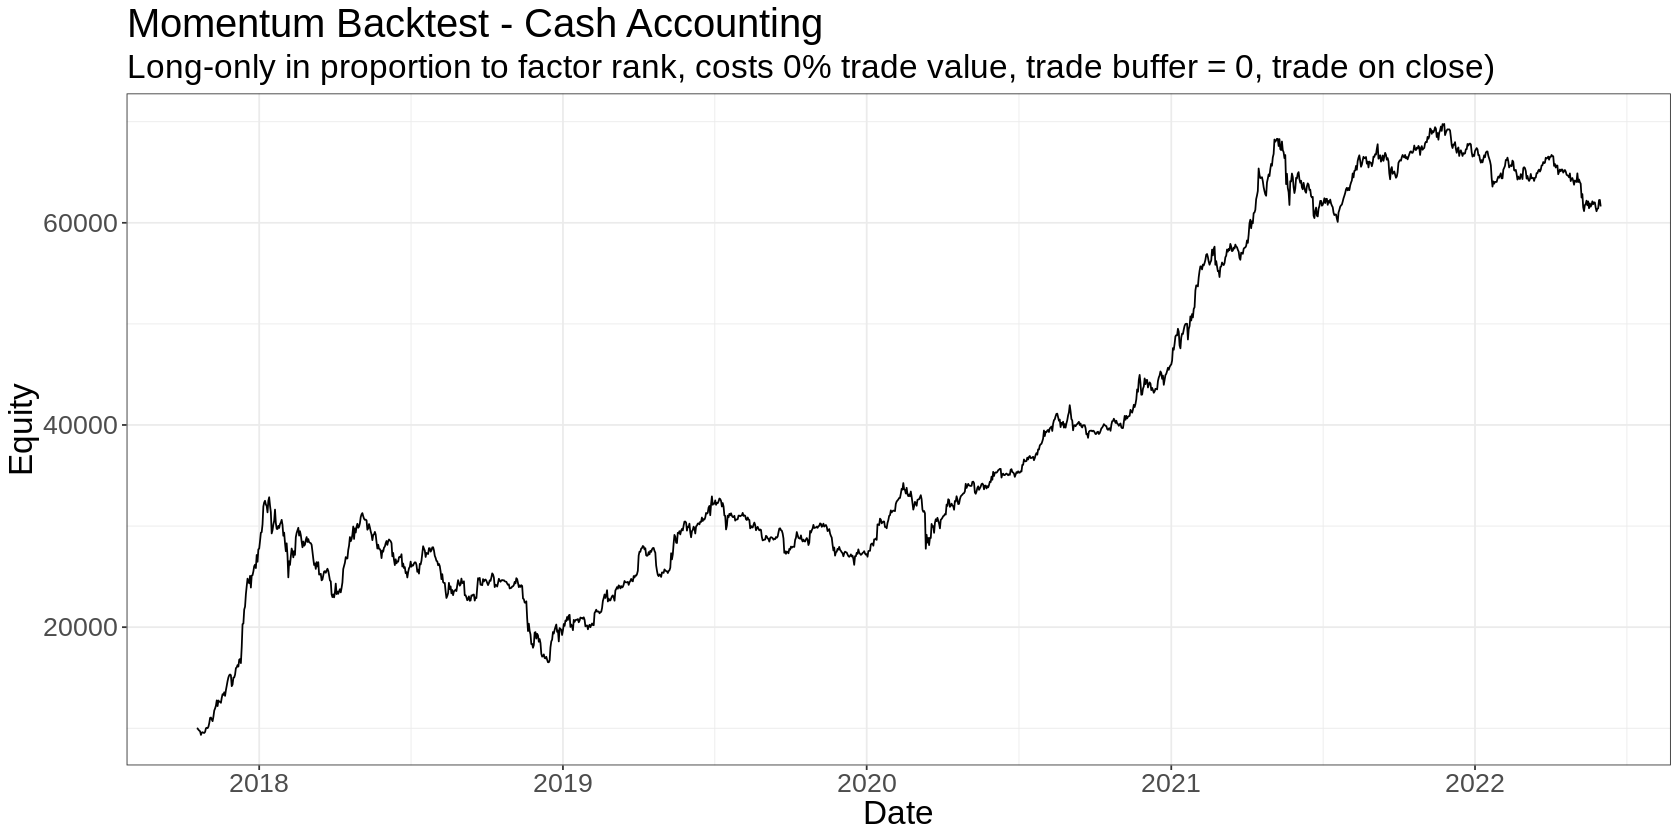

In [31]:
# cost-free backtest

# simulation parameters
initial_cash <- 10000
capitalise_profits <- FALSE  # remain fully invested?
trade_buffer <- 0.
fee_tier <- 0.
commission_pct <- fees$fee[fees$tier==fee_tier]

# simulation
results_df <- cash_backtest(backtest_prices, backtest_theo_weights, trade_buffer, initial_cash, commission_pct, capitalise_profits)
p <- plot_results(results_df)
p + labs(subtitle = glue("Long-only in proportion to factor rank, costs {commission_pct*100}% trade value, trade buffer = {trade_buffer}, trade on close)"))

### Long only when 20d momo is positive

Issues with this:
* could get highly concentrated
* needs checking

In [32]:
# weight by rank long only when momo20 is positive
backtest_df <- universe %>% 
  filter(date >= universe_start_date) %>% 
  select(ticker, date, price_usd, is_index, momo20) %>% 
  # can't filter on is_index because we need price on day after it drops out of index
  # instead, replace momo values with NA if not in index then rank each day
  mutate(universe_momo20 = case_when(is_index == TRUE & momo20 > 0 ~ momo20, TRUE ~ NA_real_)) %>%
  group_by(date) %>%
  mutate(
    rank = row_number(universe_momo20),
    theo_weight = rank/sum(rank, na.rm = TRUE)
  ) %>% 
  select(ticker, date, price_usd, theo_weight) %>% 
  pivot_wider(names_from = ticker, values_from = c(price_usd, theo_weight))  # pivot wider guarantees prices and theo_weight are date aligned

head(backtest_df)

date,price_usd_BCH,price_usd_BNB,price_usd_BTC,price_usd_DOGE,price_usd_ETH,price_usd_KNC,price_usd_LTC,price_usd_OMG,price_usd_XRP,⋯,theo_weight_BAL,theo_weight_YFI,theo_weight_SRM,theo_weight_CRV,theo_weight_SUSHI,theo_weight_UNI,theo_weight_AAVE,theo_weight_ALPHA,theo_weight_1INCH,theo_weight_PERP
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2017-10-18,338.7678,1.317849,5583.870,0.0010289347,313.2929,1.162461,60.69765,7.854567,0.2180179,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2017-10-19,329.9444,1.286488,5708.313,0.0010451067,308.3612,1.114841,59.78077,7.827557,0.2137977,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2017-10-20,327.3707,1.240682,6000.883,0.0010452918,304.1048,1.044030,60.26844,7.305775,0.2075473,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2017-10-21,322.5177,1.233071,6030.208,0.0009986687,299.9645,1.025443,58.05432,7.405425,0.2081025,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2017-10-22,330.7723,1.215623,5996.598,0.0010439447,294.8625,1.007951,56.64666,7.724162,0.2014042,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2017-10-23,312.0320,1.181881,5888.250,0.0010124827,285.2723,0.957936,54.64016,7.693838,0.1936669,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [33]:
# get weights as a wide matrix (could do equal weight, in proportion to factor/signal, top n etc)
# here we do proportional to factor rank and allow long only when momo20 is positive
# note that date column will get converted to unix timestamp
# note that when our universe is young, we might not have 10 tradables since we need some lookback period to calculate the first factor value for the tenth asset.
backtest_theo_weights <- backtest_df %>% 
  select(date, starts_with("theo_weight_")) %>% 
  data.matrix()

# NA weights should be zero
backtest_theo_weights[is.na(backtest_theo_weights)] <- 0

head(backtest_theo_weights)

# get prices as a wide matrix
# note that date column will get converted to unix timestamp
backtest_prices <- backtest_df %>% 
  select(date, starts_with("price_")) %>% 
  data.matrix()

head(backtest_prices)

date,theo_weight_BCH,theo_weight_BNB,theo_weight_BTC,theo_weight_DOGE,theo_weight_ETH,theo_weight_KNC,theo_weight_LTC,theo_weight_OMG,theo_weight_XRP,⋯,theo_weight_BAL,theo_weight_YFI,theo_weight_SRM,theo_weight_CRV,theo_weight_SUSHI,theo_weight_UNI,theo_weight_AAVE,theo_weight_ALPHA,theo_weight_1INCH,theo_weight_PERP
17457,0,0.00000000,0.3333333,0,0.1333333,0,0.2666667,0,0.2000000,⋯,0,0,0,0,0,0,0,0,0,0
17458,0,0.04761905,0.2857143,0,0.0952381,0,0.2380952,0,0.1904762,⋯,0,0,0,0,0,0,0,0,0,0
17459,0,0.00000000,0.4000000,0,0.1000000,0,0.3000000,0,0.2000000,⋯,0,0,0,0,0,0,0,0,0,0
17460,0,0.00000000,0.5000000,0,0.0000000,0,0.3333333,0,0.1666667,⋯,0,0,0,0,0,0,0,0,0,0
17461,0,0.00000000,0.5000000,0,0.0000000,0,0.3333333,0,0.0000000,⋯,0,0,0,0,0,0,0,0,0,0
17462,0,0.00000000,0.6666667,0,0.0000000,0,0.3333333,0,0.0000000,⋯,0,0,0,0,0,0,0,0,0,0


date,price_usd_BCH,price_usd_BNB,price_usd_BTC,price_usd_DOGE,price_usd_ETH,price_usd_KNC,price_usd_LTC,price_usd_OMG,price_usd_XRP,⋯,price_usd_BAL,price_usd_YFI,price_usd_SRM,price_usd_CRV,price_usd_SUSHI,price_usd_UNI,price_usd_AAVE,price_usd_ALPHA,price_usd_1INCH,price_usd_PERP
17457,338.7678,1.317849,5583.870,0.0010289347,313.2929,1.162461,60.69765,7.854567,0.2180179,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
17458,329.9444,1.286488,5708.313,0.0010451067,308.3612,1.114841,59.78077,7.827557,0.2137977,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
17459,327.3707,1.240682,6000.883,0.0010452918,304.1048,1.044030,60.26844,7.305775,0.2075473,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
17460,322.5177,1.233071,6030.208,0.0009986687,299.9645,1.025443,58.05432,7.405425,0.2081025,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
17461,330.7723,1.215623,5996.598,0.0010439447,294.8625,1.007951,56.64666,7.724162,0.2014042,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
17462,312.0320,1.181881,5888.250,0.0010124827,285.2723,0.957936,54.64016,7.693838,0.1936669,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


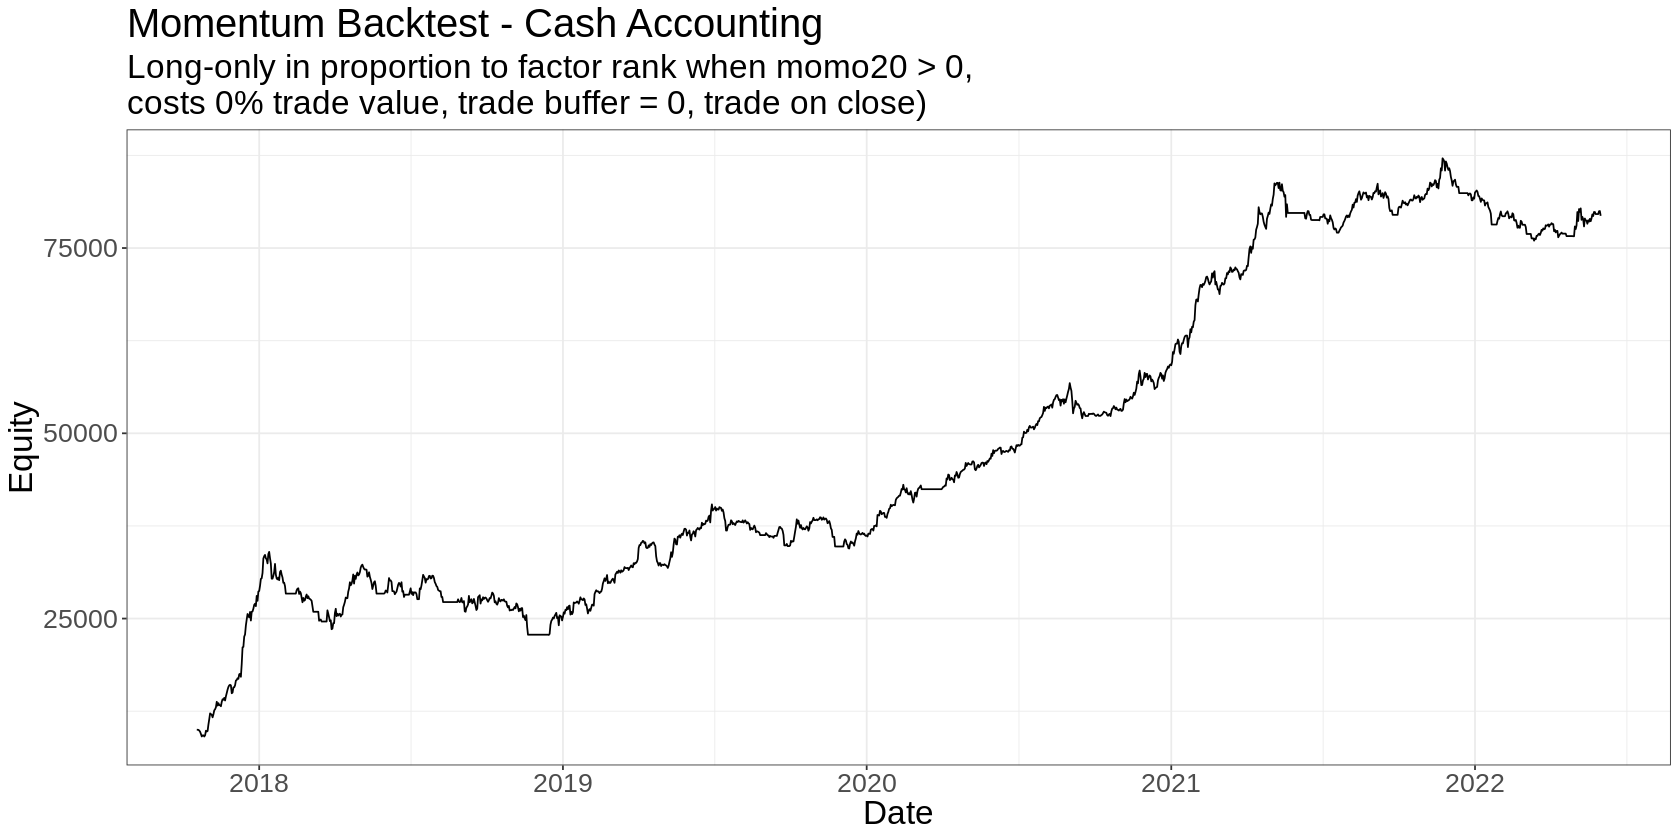

In [34]:
# cost-free backtest

# simulation parameters
initial_cash <- 10000
capitalise_profits <- FALSE  # remain fully invested?
trade_buffer <- 0.
fee_tier <- 0.
commission_pct <- fees$fee[fees$tier==fee_tier]

# simulation
results_df <- cash_backtest(backtest_prices, backtest_theo_weights, trade_buffer, initial_cash, commission_pct, capitalise_profits)
p <- plot_results(results_df)
p + labs(
  subtitle = glue(
    "Long-only in proportion to factor rank when momo20 > 0, 
    costs {commission_pct*100}% trade value, trade buffer = {trade_buffer}, trade on close)"
    )
)

With costs

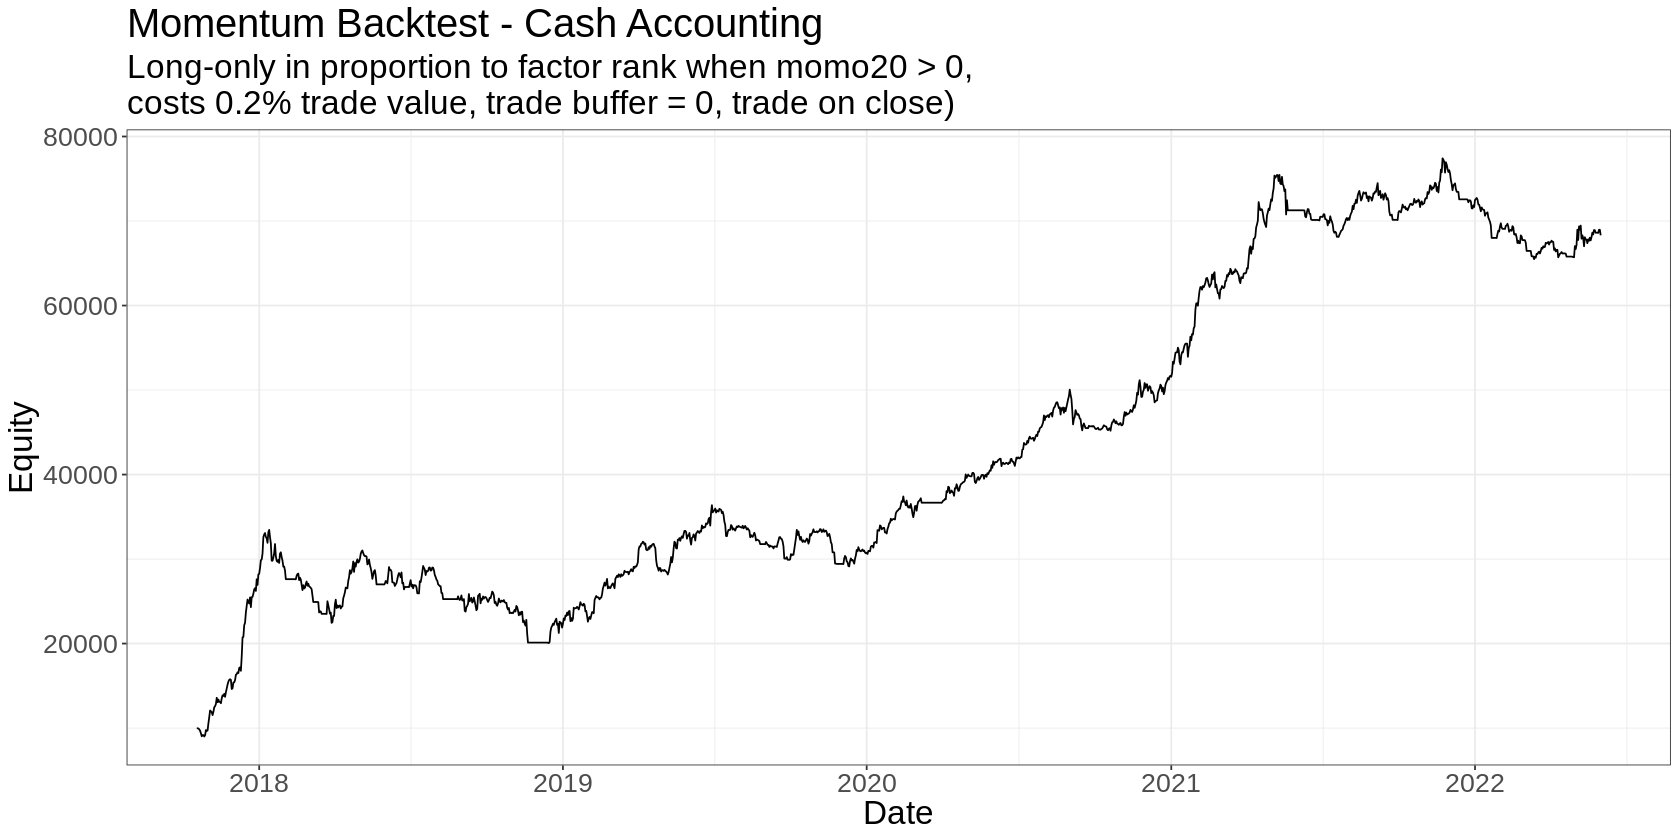

In [35]:
fee_tier <- 3
trade_buffer <- 0.
commission_pct <- fees$fee[fees$tier==fee_tier]

results_df <- cash_backtest(backtest_prices, backtest_theo_weights, trade_buffer, initial_cash, commission_pct, capitalise_profits)
plot_results(results_df) + labs(
  subtitle = glue(
    "Long-only in proportion to factor rank when momo20 > 0, 
    costs {commission_pct*100}% trade value, trade buffer = {trade_buffer}, trade on close)"
    )
)

Find sharpe-optimal trade buffer:

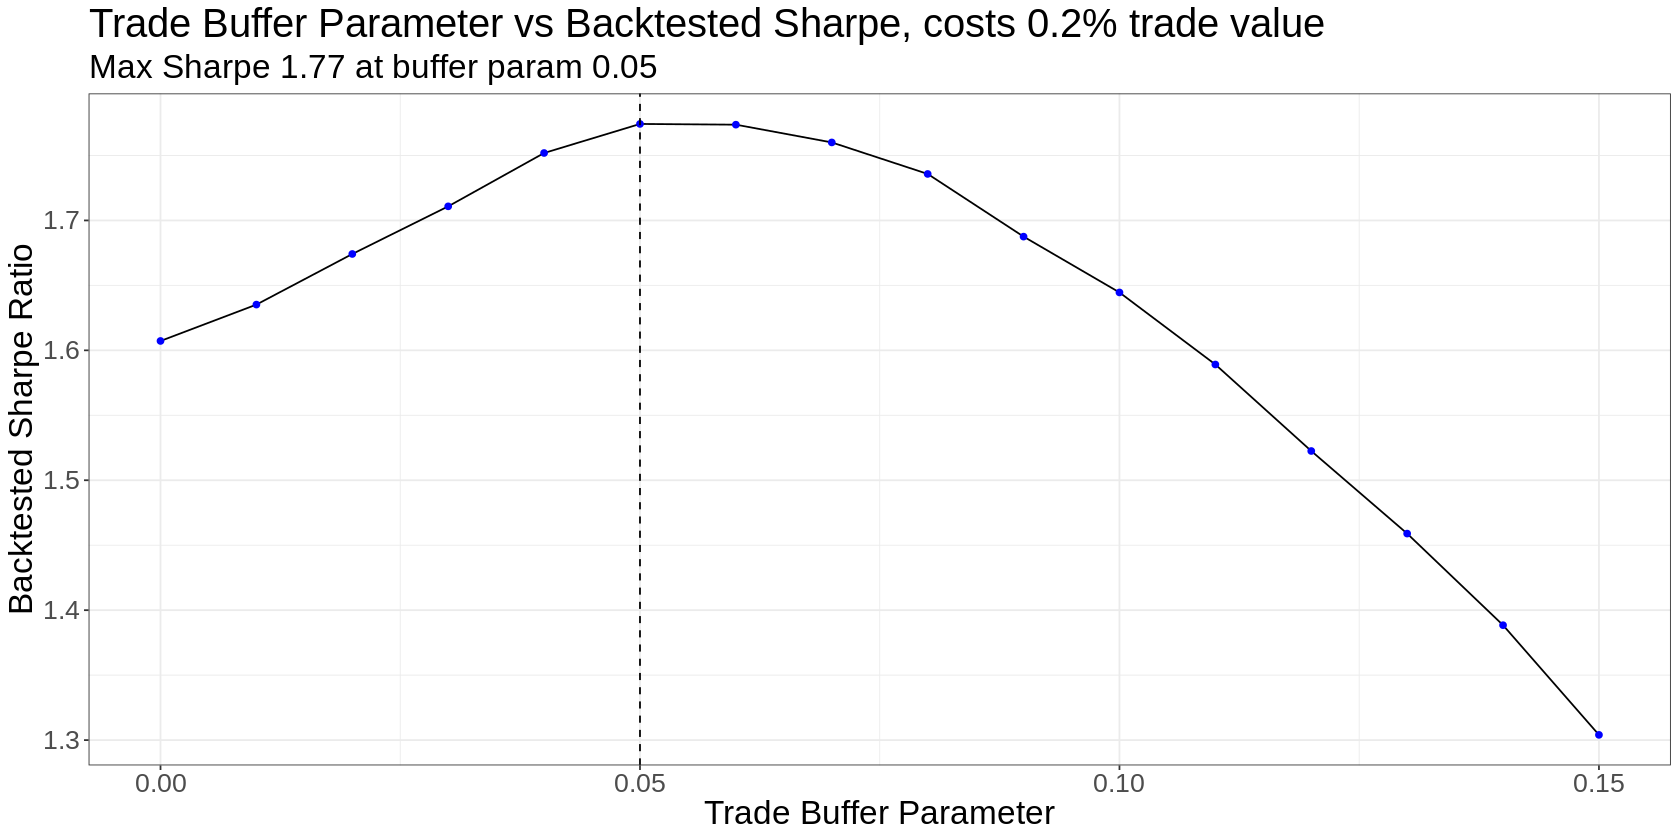

In [36]:
sharpes <- list()
trade_buffers <- seq(0, 0.15, by = 0.01)
for(trade_buffer in trade_buffers) {
  sharpes <- c(
    sharpes, 
    cash_backtest(backtest_prices, backtest_theo_weights, trade_buffer, initial_cash, commission_pct, capitalise_profits) %>%
      calc_sharpe()
  )
}

sharpes <- unlist(sharpes)
data.frame(
  trade_buffer = trade_buffers, 
  sharpe = sharpes
) %>%
  ggplot(aes(x = trade_buffer, y = sharpe)) +
    geom_line() +
    geom_point(colour = "blue") +
    geom_vline(xintercept = trade_buffers[which.max(sharpes)], linetype = "dashed") +
    labs(
      x = "Trade Buffer Parameter",
      y = "Backtested Sharpe Ratio",
      title = glue("Trade Buffer Parameter vs Backtested Sharpe, costs {commission_pct*100}% trade value"),
      subtitle = glue("Max Sharpe {round(max(sharpes), 2)} at buffer param {trade_buffers[which.max(sharpes)]}")
    )

Backtest with sharpe-optimal trade buffer

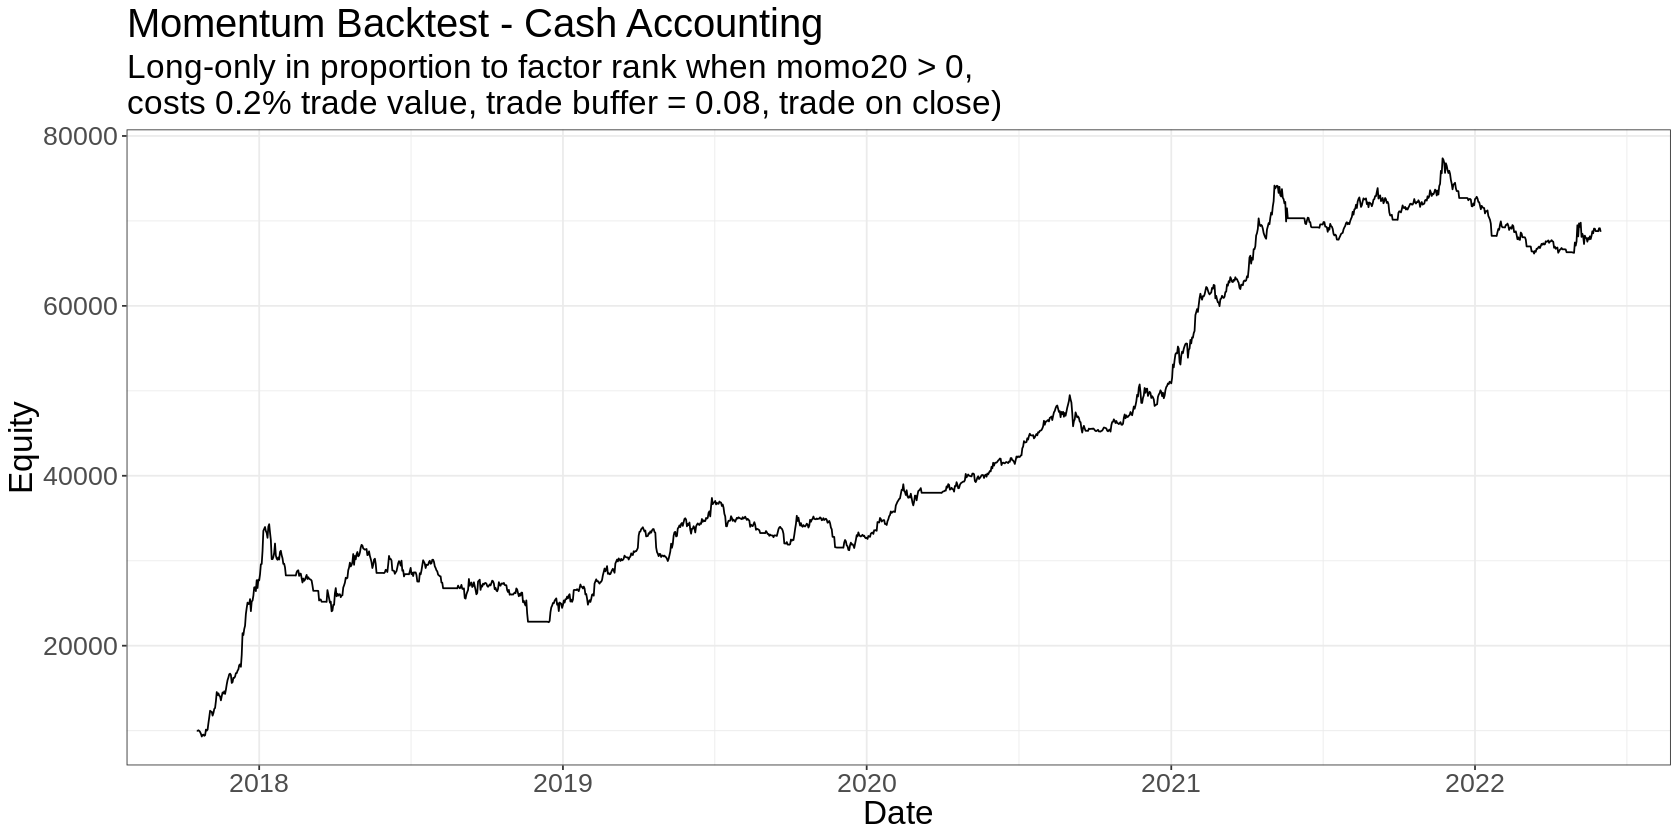

In [37]:
trade_buffer <- 0.08

results_df <- cash_backtest(backtest_prices, backtest_theo_weights, trade_buffer, initial_cash, commission_pct, capitalise_profits)
p <- plot_results(results_df)
p + labs(
  subtitle = glue(
    "Long-only in proportion to factor rank when momo20 > 0, 
    costs {commission_pct*100}% trade value, trade buffer = {trade_buffer}, trade on close)"
  )
)

In [38]:
calc_sharpe(results_df)

[1] 1.735773